# **Preparation**

``note: jalankan semua code ini & pastikan pakai GPU biar cepet``

## **Import Library**

In [1]:
# Install
!pip install PyDOE
!pip install tensorflow==1.15

  Created wheel for PyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=2a00e25ea38e0acb3914ca02d993374f00a0a156e8ebf69aaaf67aa0103c7f86
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built PyDOE
     |████████████████████████████████| 412.3 MB 22 kB/s 
     |████████████████████████████████| 503 kB 36.3 MB/s 
     |████████████████████████████████| 3.8 MB 34.4 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=4f3c9b8438f39b0c2c204d31fd30551ce88d82ea7c6cb583bcabf8b9fea6ce26
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Atte

In [26]:
# Import
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scipy.io
import tensorflow as tf

import time
import timeit
import math as m
import scipy.interpolate
from scipy import interpolate

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs


In [2]:
tf.__version__

'1.15.0'

## **Class & Functions**

### **PINN Class**

In [45]:
# @tf.function
class PinnVP:

    def __init__(self, data, params, exist_model=False, file_dir=""):
        self.unpack(data, params)
        self.initialize_variables()

        # Initialize Neural Network Computational Graph
        # Weight & biases
        if exist_model:
            print("Loading NN parameters ...")
            if self.adaptive_coef:
                self.weights, self.biases, self.coef = self.load_model(file_dir)
            else:
                self.weights, self.biases = self.load_model(file_dir)
        else:
            if self.adaptive_coef:
                self.weights, self.biases, self.coef = self.initialize_network()
            else:
                self.weights, self.biases = self.initialize_network()
        
        # Placeholder & Graph
        # Placeholder (where we put input)
        self.initialize_placeholders()

        # Computational graph of Physics-Informed
        self.graph_network()

        # Computational graph of loss
        self.graph_loss()
        
        # Optimizers
        self.initialize_optimizers()

        # Session
        self.initialize_session()

    def callback_adap(self, loss_test, loss_total, loss_collo, loss_neu, loss_dir, coef):
        self.count += 1
        self.loss_test_log.append(loss_test)
        self.loss_total_log.append(loss_total)
        self.loss_collo_log.append(loss_collo)
        self.loss_dir_log.append(loss_dir)
        self.loss_neu_log.append(loss_neu)
        self.coef_log.append(coef[0][0])
        
        if self.count % self.verboses_newton == 0:    
            print("iter: %d, Loss_Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Neumann: %.4e, Loss Dirichlet: %.4e, coef: %.4e" %
                  (self.count, loss_test, loss_total, loss_collo, loss_neu, loss_dir, coef))

    def callback(self, loss_test, loss_total, loss_collo, loss_neu, loss_dir):
        self.count += 1
        self.loss_test_log.append(loss_test)
        self.loss_total_log.append(loss_total)
        self.loss_collo_log.append(loss_collo)
        self.loss_dir_log.append(loss_dir)
        self.loss_neu_log.append(loss_neu)
        
        if self.count % self.verboses_newton == 0:    
            print("iter: %d, Loss_Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Neumann: %.4e, Loss Dirichlet: %.4e" %
                  (self.count, loss_test, loss_total, loss_collo, loss_neu, loss_dir))
    
    def normalize_input_data(self):
        # Normalize data
        x_c = self.normalize_data(data=self.x_c, axis="x")
        y_c = self.normalize_data(data=self.y_c, axis="y")
        x_left = self.normalize_data(data=self.x_left, axis="x")
        y_left = self.normalize_data(data=self.y_left, axis="y")
        x_right = self.normalize_data(data=self.x_right, axis="x")
        y_right = self.normalize_data(data=self.y_right, axis="y")
        x_lower = self.normalize_data(data=self.x_lower, axis="x")
        y_lower = self.normalize_data(data=self.y_lower, axis="y")
        x_upper = self.normalize_data(data=self.x_upper, axis="x")
        y_upper = self.normalize_data(data=self.y_upper, axis="y")
        x_test = self.normalize_data(data=self.x_test, axis="x")
        y_test = self.normalize_data(data=self.y_test, axis="y")

        return x_c, y_c, x_left, y_left, x_right, y_right, x_lower, y_lower, x_upper, y_upper, x_test, y_test

    def fetch_minibatch(self, x, y):
        mini_batches = []
        batch_size = self.batch_size
        data = np.hstack((x, y))
        np.random.shuffle(data)
        n_mini_batches = data.shape[0] // batch_size

        i = 0
        for i in range(n_mini_batches):
            mini_batch = data[i*batch_size:(i+1)*batch_size, :]
            x_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append(np.hstack((x_mini, y_mini)))

        return mini_batches

    def create_input_dict(self):
        # Normalize data
        x_c, y_c, x_left, y_left, x_right, y_right, x_lower, y_lower, x_upper, y_upper, x_test, y_test = self.normalize_input_data()

        tf_dict = {self.x_c_tf: x_c, self.y_c_tf: y_c,                              # collocation data
                        self.x_left_tf: x_left, self.y_left_tf: y_left,             # left data (pts)
                        self.u_left_tf: self.u_left, 
                        self.x_right_tf: x_right, self.y_right_tf: y_right,         # right data
                        self.u_right_tf: self.u_right,
                        self.x_lower_tf: x_lower, self.y_lower_tf: y_lower,         # lower data
                        self.u_lower_tf: self.u_lower,  
                        self.x_upper_tf: x_upper, self.y_upper_tf: y_upper,         # Upper data
                        self.u_upper_tf: self.u_upper,
                        self.x_test_tf: x_test, self.y_test_tf: y_test,             # Test data
                        self.u_test_tf: self.u_test}

        return tf_dict
       
    def fit_adam(self):
        # Change flag
        self.adam_started = True

        # Start iteration
        print("START TRAINING ADAM")
        print("-------------------------------------------------------------")
        start_time = timeit.default_timer()

        for epoch in range(self.epochs):
            # Create dictionary
            self.tf_dict = self.create_input_dict()

            # Run Adam optimizer
            tf_dict = self.tf_dict
            self.sess.run(self.train_op_adam, tf_dict)
            
            if self.adaptive_coef:
                if epoch % self.verboses_adam == 0:
                    coef_val = self.sess.run(self.coef, tf_dict)
                    self.coef_val = coef_val[0][0]
                    self.coef_log.append(self.coef_val)
                    
            # Print
            if epoch % self.verboses_adam == 0:
                # Calculate loss
                loss_total_ = self.sess.run(self.loss_total, tf_dict)
                loss_collo_ = self.sess.run(self.loss_collo, tf_dict)
                loss_dir_ = self.sess.run(self.loss_dir, tf_dict)
                loss_neu_ = self.sess.run(self.loss_neu, tf_dict)
                loss_test_ = self.sess.run(self.loss_test, tf_dict)

                # Save loss
                self.loss_total_log.append(loss_total_)
                self.loss_collo_log.append(loss_collo_)
                self.loss_dir_log.append(loss_dir_)
                self.loss_neu_log.append(loss_neu_)
                self.loss_test_log.append(loss_test_)

                elapsed = timeit.default_timer() - start_time
                print("iter: %d, Loss Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Neumann: %.4e, Loss Dirichlet: %.4e, time: %.2fs" %
                      (epoch+self.last_adam_iter, loss_test_, loss_total_, loss_collo_, loss_neu_, loss_dir_, elapsed))
                
                if self.adaptive_coef:
                    print(f"coef coefficients: {self.coef_val:5f}")

                start_time = timeit.default_timer()

#             if epoch % self.saver == 0:
#                 self.save_model(f"model-{epoch}.pickle")
#                 self.save_loss(f"model-loss-{epoch}.csv")
#                 print("model & loss saved")

        self.last_adam_iter += self.epochs
        self.lr_init = self.coef_val
    
    def fit_newton(self):
        # Change flag
        self.newton_started = True
        self.count += 0

        # Normalize data
        (x_c, y_c, 
         x_left, y_left, 
         x_right, y_right, 
         x_lower, y_lower,
         x_upper, y_upper,
         x_test, y_test) = self.normalize_input_data()

        tf_dict = {self.x_c_tf: x_c, self.y_c_tf: y_c,                          # collocation data
                   self.x_left_tf: x_left, self.y_left_tf: y_left,              # left data (pts)
                   self.u_left_tf: self.u_left, 
                   self.x_right_tf: x_right, self.y_right_tf: y_right,          # right data
                   self.u_right_tf: self.u_right,
                   self.x_lower_tf: x_lower, self.y_lower_tf: y_lower,          # lower data
                   self.u_lower_tf: self.u_lower,  
                   self.x_upper_tf: x_upper, self.y_upper_tf: y_upper,          # Upper data
                   self.u_upper_tf: self.u_upper,
                   self.x_test_tf: x_test, self.y_test_tf: y_test,             # Test data
                   self.u_test_tf: self.u_test}
               
        if self.adaptive_coef:
            self.train_op_newton.minimize(self.sess,
                                          feed_dict=tf_dict,
                                          fetches=[self.loss_test, self.loss_total,
                                                  self.loss_collo, self.loss_neu, 
                                                  self.loss_dir, self.coef],
                                          loss_callback=self.callback_adap)
        else:
            self.train_op_newton.minimize(self.sess,
                                          feed_dict=tf_dict,
                                          fetches=[self.loss_test, self.loss_total,
                                                  self.loss_collo, self.loss_neu, 
                                                  self.loss_dir],
                                          loss_callback=self.callback)

    def find_neu(self):
        self.grad_x_left = tf.gradients(self.u_left_pred, self.x_left_tf)[0] / self.sigma_x
        self.grad_x_right = tf.gradients(self.u_right_pred, self.x_right_tf)[0] / self.sigma_x
        self.grad_y_lower = tf.gradients(self.u_lower_pred, self.y_lower_tf)[0] / self.sigma_y
        
        k_left = self.k_coef_left.flatten()[:, None].astype(np.float32)
        k_right = self.k_coef_right.flatten()[:, None].astype(np.float32)
        k_lower = self.k_coef_lower.flatten()[:, None].astype(np.float32)
        self.coef_left = tf.multiply(k_left, self.grad_x_left)
        self.coef_right = tf.multiply(k_right, self.grad_x_right)
        self.coef_lower = tf.multiply(k_lower, self.grad_y_lower)
        
    def graph_loss(self):
        # Test
        self.loss_test = tf.math.sqrt(tf.reduce_mean(tf.square(self.u_test_tf - self.u_test_pred)))
       
        # Collocation points
        self.loss_collo = tf.reduce_mean(tf.square(self.f_pred_u)) \
        
        # Boundary
        self.find_neu()
        self.loss_dir = tf.reduce_mean(tf.square(self.u_upper_pred-self.u_upper_tf))
        self.loss_neu = (tf.reduce_mean(tf.square(self.coef_left-self.u_left_tf)) \
                        + tf.reduce_mean(tf.square(self.coef_right-self.u_right_tf)) \
                        + tf.reduce_mean(tf.square(self.coef_lower-self.u_lower_tf)))

        if self.adaptive_coef:
            self.loss_collo = (1 / (self.scale_factor * self.coef[0])) * self.loss_collo
        else:
            self.loss_collo = self.coef_val*(self.loss_collo)
            
        self.loss_total = self.loss_neu + self.loss_collo + self.loss_dir 

    def graph_network(self):
        # Test data
        (self.u_test_pred) = self.net_dnn(self.x_test_tf, self.y_test_tf)
        
        # Predict data
        (self.u_pred) = self.net_dnn(self.x_tf, self.y_tf)
        
        # Collocation points
        (self.f_pred_u) = self.net_physics(self.x_c_tf, self.y_c_tf)
        
        # left
        (self.u_left_pred) = self.net_dnn(self.x_left_tf, self.y_left_tf)
        
        # right
        (self.u_right_pred) = self.net_dnn(self.x_right_tf, self.y_right_tf)
        
        # Lower
        (self.u_lower_pred) = self.net_dnn(self.x_lower_tf, self.y_lower_tf)
        
        # Upper
        (self.u_upper_pred) = self.net_dnn(self.x_upper_tf,self.y_upper_tf)

    def load_model(self, file_dir):
        weights = []
        biases = []
        if self.adaptive_coef:
            coef = []
        num_layers = len(self.layers)
        
        with open(file_dir, 'rb') as f:
            if self.adaptive_coef:
                dnn_weights, dnn_biases, dnn_coef = pickle.load(f)
                coef = tf.Variable(dnn_coef)

            else:
                dnn_weights, dnn_biases= pickle.load(f)

            # stored model mush has the same layers
            assert num_layers == (len(dnn_weights)+1)

            for num in range(0, num_layers-1):
                W = tf.Variable(dnn_weights[num])
                b = tf.Variable(dnn_biases[num])
                weights.append(W)
                biases.append(b)
                print('Loaded NN parameters successfully ...')
            
        if self.adaptive_coef:
            return weights, biases, coef
        else:
            return weights, biases

    def initialize_network(self):
        # Initialize
        weights = []
        biases = []
        num_layers = len(self.layers)
        layers = self.layers

        # Create network
        for lyr in range(num_layers-1):
            # initialize weights from Xavier initialization
            np.random.seed(self.random_seed)
            W = self.xavier_init(size=[layers[lyr], 
                                       layers[lyr+1]])

            # initialize biases = 0
            np.random.seed(self.random_seed)
            b = tf.Variable(tf.zeros([1, layers[lyr+1]],
                                     dtype=tf.float32),
                            dtype=tf.float32)

            # Append generated weights & biases to the list
            weights.append(W)
            biases.append(b)

        if self.adaptive_coef:
            np.random.seed(self.random_seed)
            coef = tf.Variable(self.coef_val * tf.ones([1, 1], dtype=tf.float32), dtype=tf.float32)
            
            return weights, biases, coef
        
        else:
            return weights, biases

    def initialize_optimizers(self):
        if self.adaptive_coef:
            variable_list = [self.coef] + self.weights + self.biases 
        else:
            variable_list = self.weights + self.biases

        self.lr_tf = tf.constant(self.lr_init, dtype=tf.float32)  
        self.optimizer_adam = tf.train.AdamOptimizer(learning_rate=self.lr_tf)
        self.train_op_adam = self.optimizer_adam.minimize(self.loss_total,
                                                        var_list=variable_list)

        self.train_op_newton = tf.contrib.opt.ScipyOptimizerInterface(
                                    self.loss_total,
                                    var_list = variable_list,
                                    method = "L-BFGS-B",
                                    options = {"maxiter": 100000,
                                               "maxfun": 100000,
                                               "maxcor": 50,
                                               "maxls": 50,
                                               "ftol": 1e11*np.finfo(float).eps}) 
    def initialize_placeholders(self):
        # Test data
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, self.x_test.shape[1]])
        self.y_test_tf = tf.placeholder(tf.float32, shape=[None, self.y_test.shape[1]])
        self.u_test_tf = tf.placeholder(tf.float32, shape=[None, self.u_test.shape[1]])
        
        # Predict data
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])

        # Collocation data
        self.x_c_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.y_c_tf = tf.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])

        # Boundary data
        # left
        self.x_left_tf = tf.placeholder(tf.float32, shape=[None, self.x_left.shape[1]])
        self.y_left_tf = tf.placeholder(tf.float32, shape=[None, self.y_left.shape[1]])
        self.u_left_tf = tf.placeholder(tf.float32, shape=[None, self.u_left.shape[1]])

        # right
        self.x_right_tf = tf.placeholder(tf.float32, shape=[None, self.x_right.shape[1]])
        self.y_right_tf = tf.placeholder(tf.float32, shape=[None, self.y_right.shape[1]])
        self.u_right_tf = tf.placeholder(tf.float32, shape=[None, self.u_right.shape[1]])

        # Lower
        self.x_lower_tf = tf.placeholder(tf.float32, shape=[None, self.x_lower.shape[1]])
        self.y_lower_tf = tf.placeholder(tf.float32, shape=[None, self.y_lower.shape[1]])
        self.u_lower_tf = tf.placeholder(tf.float32, shape=[None, self.u_lower.shape[1]])

        self.x_upper_tf = tf.placeholder(tf.float32, shape=[None, self.x_upper.shape[1]])
        self.y_upper_tf = tf.placeholder(tf.float32, shape=[None, self.y_upper.shape[1]])
        self.u_upper_tf = tf.placeholder(tf.float32, shape=[None, self.u_upper.shape[1]])

    def initialize_session(self):
        tf_config = tf.ConfigProto(allow_soft_placement=True,
                                   log_device_placement=True)
        self.sess = tf.Session(config=tf_config)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_variables(self):
        # For saving loss
        self.loss_total_log = []
        self.loss_collo_log = []
        self.loss_test_log = []
        self.count = 0
        self.newton_started = False
        self.adam_started = False
        self.last_adam_iter = 0

        self.loss_dir_log = []
        self.loss_neu_log = []
        self.beta_log = []
        self.coef_log = []
        
    def net_dnn(self, x, y):
        # Find results
        X = tf.concat([x, y], 1)
        results = self.net_forward(X)

        return results


    def net_forward(self, X):
        num_layers = len(self.weights)+1
        H = X

        for lyr in range(num_layers-2):
            W = self.weights[lyr]
            b = self.biases[lyr]

            Wx_plus_b = tf.add(tf.matmul(H, W), b)
            H = tf.tanh(Wx_plus_b)

        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)

        return Y

    def find_k(self,xi,nx,ny,view=True):
        
        gridx, gridy = self.creategrid(nx, ny, view=False)
        gx = self.calculatealpha(xi, gridx, gridy, 0.2, view=True)
        kc, kc_x, kc_y = self.grad_k(k_data=gx, xc=self.x_c, yc=self.y_c, view=True)
        return kc, kc_x, kc_y

    def grad_k(self, k_data, xc, yc,view=False):
        grad_k_data_x = np.gradient(k_data)[1]
        grad_k_data_y = np.gradient(k_data)[0]
        
        x = np.linspace(-0.5, 0.5, 101)
        y = np.linspace(-0.5, 0.5, 101)
        xx, yy = np.meshgrid(x, y)
        xx_ = xx.flatten()[:, None]
        yy_ = yy.flatten()[:, None]
        
        k_coef_left = np.zeros(shape=(self.x_left.shape))
        k_coef_right = np.zeros(shape=(self.x_right.shape))
        k_coef_lower = np.zeros(shape=(self.x_lower.shape))
        
        kc = np.zeros(shape=(xc.shape))
        kc_x = np.zeros(shape=(xc.shape))
        kc_y = np.zeros(shape=(xc.shape))
        
        f = interpolate.LinearNDInterpolator(np.array([xx_, yy_])[:,:,0].T, k_data.flatten()[:,None])
        f_x = interpolate.LinearNDInterpolator(np.array([xx_, yy_])[:,:,0].T, grad_k_data_x.flatten()[:,None])
        f_y = interpolate.LinearNDInterpolator(np.array([xx_, yy_])[:,:,0].T, grad_k_data_y.flatten()[:,None])
        
        for i in range(0, len(xc)):
            kc[i] = f(xc[i], yc[i])
            kc_x[i] = f_x(xc[i], yc[i])
            kc_y[i] = f_y(xc[i], yc[i])
        for i in range(0, len(k_coef_left)):
            k_coef_left[i] = f(self.x_left[i], self.y_left[i])
            k_coef_right[i] = f(self.x_right[i], self.y_right[i])
            k_coef_lower[i] = f(self.x_lower[i], self.y_lower[i])
        self.k_coef_left = k_coef_left
        self.k_coef_right = k_coef_right
        self.k_coef_lower = k_coef_lower
        if view:
            vmin = np.min(k_data)
            vmax = np.max(k_data)
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=300, constrained_layout=False)
            # Unpack
            cf = ax.imshow(k_data, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
            ax.set_xlim(-0.5,0.5)
            ax.set_ylim(-0.5,0.5)

            ax.set_title("Diffusion Coefficient", fontsize=23)

            ax.set_xlabel('$x$ (m)', fontsize=20)
            ax.set_ylabel('$y$ (m)', fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=15)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="2%", pad=0.1)
            cb = fig.colorbar(cf, cax=cax)

            ticks = np.linspace(vmin, vmax, 3)
            ticks = np.round(ticks, 2)
            ticks[-1] = ticks[-1] - 0.01
            cb.set_ticks(ticks)
            cb.ax.tick_params(labelsize=16)
            cb.ax.set_title("$k$[W/m\u2103]", fontsize=18)
            plt.show()
            
#             fig = plt.figure()
#             plt.scatter(xc, yc, c=kc_x, cmap=cm.jet)
#             plt.colorbar()
#             plt.title("k x collocation")
            
#             fig = plt.figure()
#             plt.scatter(xc, yc, c=kc_y, cmap=cm.jet)
#             plt.colorbar()
#             plt.title("k y collocation")
#             plt.show()
        
        return kc, kc_x, kc_y
        

    def calcB(self):
        blist = []
        for i in range(np.size(self.z,0)):
            x = self.z[i, 0]
            y = self.z[i, 1]
            if (x >= -0.3 and x <= -0.2) and ((y >= -0.3 and y <= -0.2)):
                blist.append(self.tdist[i])
            else:
                pass
        blist = np.array(blist)
        TavgB = np.sum(blist*(0.01**2)) / 0.01
        return TavgB

    def calculatealpha(self, xi, gridx, gridy, theta=0.2, view=False):
        grfx, grfy = self.rndfgrid()
        M, li, phii = self.grandomfield(theta,grfx,grfy)
        self.z = np.hstack((gridx.reshape(self.nn, 1), gridy.reshape(self.nn, 1)))
        gx = np.zeros(shape=[np.size(self.z,0)])
        for i in range(np.size(self.z,0)):
            gx[i] = self.calcgz(self.z[i,:],M,xi,li,phii)
        gx = gx.reshape((np.size(gridx,0), np.size(gridx,1)))

        if view:
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            surf = ax.plot_surface(gridx, gridy,gx,cmap=cm.coolwarm, linewidth=0, antialiased=False)
            plt.show()

        kx = np.exp(1 + gx*0.3)
        return kx

    def creategrid(self, nx=100, ny=100, view=False):
        """
        Create discretization for finite difference heat equation solver.
        Args:
             - nx (int): number of spacing on X direction. Default to 100. (number of points is nx+1)
             - ny (int): number of spacing on Y direction. Default to 100. (number of points is ny+1)
             - view (bool): visualize grid or not. Default to False.
         Returns:
             - gridx (nparray): x coordinates for each point across the space.
             - gridy (nparray): y coordinates for each point across the space.
        """
        self.nx = nx
        self.ny = ny
        x=(-0.5, 0.5)
        y=(-0.5, 0.5)
        self.ndimen = 2
        self.x0 = x[0]
        self.y0 = y[0]
        self.x1 = x[1]
        self.y1 = y[1]
        self.length = self.x1 - self.x0
        self.width = self.y1 - self.y0
        xx = np.linspace(self.x0, self.x1, nx + 1)
        yy = np.linspace(self.y0, self.y1, ny + 1)
        self.nn = (nx + 1) * (ny + 1)
        gridx, gridy = np.meshgrid(xx, yy)
        self.dx = self.length / nx
        self.dy = self.width / ny

        if view is True:
            for i in range(nx + 1):
                temp1 = np.array([[-0.5, yy[i]], [0.5, yy[i]]])
                temp2 = np.array([[xx[i], -0.5], [xx[i], 0.5]])
                plt.plot(temp1[:, 0], temp1[:, 1], 'k')
                plt.plot(temp2[:, 0], temp2[:, 1], 'k')
            plt.show()

        return gridx, gridy

    def rndfgrid(self, nx=10, ny=10, view=False):
        """
        Create RGF nodes in the domain.
        Args:
            nx (int): number of spacing on X direction. Default to 10. (number of points is nx+1)
            ny (int): number of spacing on Y direction. Default to 10. (number of points is ny+1)
            view (bool): display nodes or not.
        Returns:
             - rf_gridx (nparray): x coordinates for each point across the space.
             - rf_gridy (nparray): y coordinates for each point across the space.
        """
        rf_xx = np.linspace(self.x0, self.x1, nx+1)
        rf_yy = np.linspace(self.y0, self.y1, ny+1)
        self.rf_nn = (nx+1) * (ny+1)
        rf_gridx, rf_gridy = np.meshgrid(rf_xx, rf_yy)

        if view is True:
            for i in range(nx+1):
                temp1 = np.array([[-0.5, rf_yy[i]], [self.rf_yy[i]]])
                temp2 = np.array([[rf_xx[i], -0.5], [rf_xx[i], 0.5]])
                plt.plot(temp1[:, 0], temp1[:, 1], 'k')
                plt.plot(temp2[:, 0], temp2[:, 1], 'k')
            plt.scatter(rf_gridx, rf_gridy)
            plt.show()

        return rf_gridx,rf_gridy

    def grandomfield(self, theta, rf_gridx, rf_gridy):
        """
        Calculate the components inside the Gaussian random field.
        Args:
            - theta (float): Lengthscale of Kernel function
            - rf_gridx (nparray):  x coordinates for each point of GRF grid across the space.
            - rf_gridy (nparray):  y coordinates for each point of GRF grid across the space.
        Returns:
            - M (int): Number of dimension of the input variables.
            - li (nparray): Eigenvalues of correlation matrix.
            - phii (nparray): Eigenvectors of correlation matrix.
        """
        self.theta = theta * np.ones(shape=[self.ndimen])
        self.zeta = np.hstack((rf_gridx.reshape(self.rf_nn, 1), rf_gridy.reshape(self.rf_nn, 1,)))
        c_zetazeta = kernel(self.zeta, self.zeta, self.ndimen, self.theta)
        li, phii = np.linalg.eigh(c_zetazeta)
        li = np.flip(li,0)
        phii = np.flip(phii,1)

        for M in range(1,self.rf_nn+1):
            temp1 = np.sum(li[:M]) / np.sum(li)
            if temp1 >= 0.99:
                break
            else:
                pass

        return M,li,phii

    def calcgz(self,z,M,xi,li,phii):
        c_zzeta = kernel(z, self.zeta, self.ndimen, self.theta).transpose()
        gztemp = np.zeros(shape=[M])
        for i in range(M):
            gztemp[i] = (xi[i]/np.sqrt(li[i])) * np.dot(phii[:,i], c_zzeta)
        gz = np.sum(gztemp)
        return gz

    def basisfunc(self,z,i,phii):
        c_zzeta = kernel(z, self.zeta, self.ndimen, self.theta).transpose()
        gztemp = np.dot(phii[:,i], c_zzeta)
        return gztemp

    def kernel(XN, XM, nvar, theta):
        if XN.ndim == 1:
            XN = np.array([XN])
        mdist = np.zeros((np.size(XN, 0), np.size(XM, 0), nvar))
        for ii in range(0, nvar):
            X1 = np.transpose(np.array([XN[:, ii]]))
            X2 = np.transpose(np.array([XM[:, ii]]))
            mdist[:, :, ii] = (cdist(X1, X2, 'euclidean') ** 2) / (theta[ii] ** 2)
        Psi = np.exp(-1 * np.sum(mdist, 2))
        return Psi
    
    def net_physics(self, x, y):
        # Find results from DNN
        T = self.net_dnn(x, y)

        # Temperature gradient
        T_x = tf.gradients(T, x)[0] / self.sigma_x
        T_xx = tf.gradients(T_x, x)[0] / self.sigma_x
        
        T_y = tf.gradients(T, y)[0] / self.sigma_y
        T_yy = tf.gradients(T_y, y)[0] / self.sigma_y
        
        # Physics error

        x = self.x_c
        y = self.y_c
        Q = np.zeros(shape=(self.x_c.shape))
        k, k_x, k_y = self.find_k(xi=self.random_variable, nx=100, ny=100)
        
        for i in range(0, x.shape[0]):            
            if (x[i] >= 0.2 and x[i] <= 0.3) and ((y[i] >= 0.2 and y[i] <= 0.3)):
                Q[i] = self.Q # W/m^3

        k_ = k.flatten()[:,None].astype(np.float32)
        k_x = k_x.flatten()[:,None].astype(np.float32)
        k_y = k_y.flatten()[:,None].astype(np.float32)

        f1 = tf.multiply(k_, T_xx) + tf.multiply(k_x, T_x)
        f2 = tf.multiply(k_, T_yy) + tf.multiply(k_y, T_y)
        f = (f1 + f2 + Q)
        
        return f
    
    def normalize_data(self, data, axis):
        if axis == "x":
            normalized_data = (data - self.mu_x) / self.sigma_x
        elif axis == "y":
            normalized_data = (data - self.mu_y) / self.sigma_y

        return normalized_data

    def predict(self, x_star, y_star):
        # Prepare the input
        x_star = (x_star - self.mu_x) / self.sigma_x
        y_star = (y_star - self.mu_y) / self.sigma_y

        # Create dictionary
        tf_dict = {self.x_tf:x_star, self.y_tf:y_star}

        # Predict
        u_star = self.sess.run(self.u_pred, tf_dict)

        return u_star        

    def save_loss(self, file_dir):
        loss_test = np.array(self.loss_test_log)
        loss_data = np.column_stack((self.loss_total_log, 
                                     self.loss_collo_log,
                                     self.loss_dir_log,
                                     self.loss_neu_log,
                                     loss_test))
        loss_df = pd.DataFrame(loss_data, columns=["total", "collo", "dirichlet", "neumann", "error_u"])
        joblib.dump(loss_df, file_dir)

    def save_model(self, file_dir):
        weights = self.sess.run(self.weights)
        biases = self.sess.run(self.biases)
        if self.adaptive_coef:
            coef = self.sess.run(self.coef)
            with open(file_dir, 'wb') as f:
                pickle.dump([weights, biases, coef], f)
                print("Save NN parameters successfully...")

        else:
            with open(file_dir, 'wb') as f:
                pickle.dump([weights, biases], f)
                print("Save NN parameters successfully...")

    def unpack(self, data, params):
        # Initialize
        self.data = data
        self.params = params

        # Unpack Parameters
        # Data-Boundary
        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]

        self.random_seed = data["train"]["random_seed"]
        
        # Data-Collocation
        self.x_c = data["train"]["collo"][:, 0:1]
        self.y_c = data["train"]["collo"][:, 1:2]
        self.n_collo = params["data"]["n_collo"]
        self.mu_x = data["train"]["mu_x"]
        self.mu_y = data["train"]["mu_y"]
        self.sigma_x = data["train"]["sigma_x"]
        self.sigma_y = data["train"]["sigma_y"]
        
        # Data-left
        self.x_left = data["train"]["left"][:, 0:1]
        self.y_left = data["train"]["left"][:, 1:2]
        self.u_left = data["train"]["left"][:, 2:3]

        # Data-right
        self.x_right = data["train"]["right"][:, 0:1]
        self.y_right = data["train"]["right"][:, 1:2]
        self.u_right = data["train"]["right"][:, 2:3]
        
        # Data-lower
        self.x_lower = data["train"]["lower"][:, 0:1]
        self.y_lower = data["train"]["lower"][:, 1:2]
        self.u_lower = data["train"]["lower"][:, 2:3]

        # Data-upper
        self.x_upper = data["train"]["upper"][:, 0:1]
        self.y_upper = data["train"]["upper"][:, 1:2]
        self.u_upper = data["train"]["upper"][:, 2:3]

        # Data-Test
        self.x_test = data["test"][:, 0:1]
        self.y_test = data["test"][:, 1:2]
        self.u_test = data["test"][:, 2:3]

        self.Q   = params["physic"]["Q"]
        self.random_variable = data["train"]["random_variable"]

        # Network
        self.layers = params["network"]["layers"]
        self.coef_val = np.array(params["network"]["coef"])
        self.verboses_newton = params["network"]["verboses_newton"]
        self.verboses_adam = params["network"]["verboses_adam"]
        self.saver = params["network"]["saver"]
        self.adaptive_coef = params["network"]["adaptive_coef"]
        self.lr_init = params["network"]["lr_init"]
        self.epochs = params["network"]["epochs"]
        self.scale_factor = params["network"]["scale_factor"]

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))

        np.random.seed(self.random_seed)
        var = tf.Variable(tf.truncated_normal([in_dim, out_dim], 
                                               stddev=xavier_stddev, 
                                               dtype=tf.float32,
                                               seed=self.random_seed), 
                           dtype=tf.float32)
        return var


### **Cases**

#### 2D Steady

##### Finite Element  (Ref: Zuhal et. al.)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy
import warnings
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
warnings.filterwarnings("ignore")


class Conduction:
    """
    Solver for 2D heat conduction with heat source on the plate and
    Gaussian random field as the conductivity coefficient.
    """

    def __init__(self, x=(-0.5, 0.5), y=(-0.5, 0.5)):
        """
        Initialize the variables
        Args:
            x (tuple): tuple of x coordinates (x0,x1)
            y (tuple): tuple of x coordinates (y0,y1)
        """
        self.ndimen = 2
        self.x0 = x[0]
        self.y0 = y[0]
        self.x1 = x[1]
        self.y1 = y[1]
        self.length = self.x1 - self.x0
        self.width = self.y1 - self.y0

    # def run_collo(self, xi, x, y):
    #     gx_collo = self.calculatealpha(xi, x, y, 0.2, view=True)
    #     return gx_collo

    # def run(self,xi,nx,ny,k,view=True):
    def run(self,xi,nx,ny,view=True):
        """
        Wrapper to run the code
        Arg:
            - xi (nparray): array of input
        Return:
            - tavgB (float): Average temperature inside region B
        """
        # self.k = k
        gridx, gridy = self.creategrid(nx, ny, view=False)
        gx = self.calculatealpha(xi, gridx, gridy, 0.2, view=True)
        self.creatematrix(gx)
        self.solve(view=view)
        tavgB = self.calcB()
        return tavgB

    def creatematrix(self, kx):
        matsize = np.size(self.z,0)
        self.coeffmat = np.zeros(shape=[matsize,matsize])

        # Create lower neumann BC
        for i in range(self.nx+1):
            self.coeffmat[i,i] = 1
            self.coeffmat[i,i+self.nx+1] = -1

        # Create upper dirichlet BC
        for i in range(-(self.nx+1),0):
            self.coeffmat[i,i] = 1

        # Create the remaining
        for i in range(self.nx+1,matsize-(self.nx+1)):
            if i % (self.nx+1) == 0: # left neumann BC
                self.coeffmat[i, i] = 1
                self.coeffmat[i, i + 1] = -1
            elif i % (self.nx+1) == self.nx: # right neumann BC
                self.coeffmat[i, i] = 1
                self.coeffmat[i, i - 1] = -1
            else:
                iloc,jloc = self.z[i,:]
                iloc = int((np.round(iloc,2) + 0.5)*100)
                jloc = int((np.round(jloc,2) + 0.5)*100)
                k1 = (kx[jloc,iloc+1] - kx[jloc,iloc+1]) / ((2*self.dx)**2)
                k2 = (kx[jloc+1,iloc] - kx[jloc-1,iloc]) / ((2*self.dy)**2)
#                 k1 = (kx[iloc+1,jloc] - kx[iloc-1,jloc]) / ((2*self.dx)**2)
#                 k2 = (kx[iloc,jloc+1] - kx[iloc,jloc-11]) / ((2*self.dy)**2)
                k3 = kx[jloc,iloc] / (self.dx**2)
                k4 = kx[jloc, iloc] / (self.dy ** 2)
                # k1 = (kx - kx) / ((2*self.dx)**2)
                # k2 = (kx - kx) / ((2*self.dy)**2)
                # k3 = kx / (self.dx**2)
                # k4 = kx / (self.dy ** 2)
                self.coeffmat[i,i] = 2*(k3+k4)
                self.coeffmat[i, i - 1] = -(k3-k1)
                self.coeffmat[i, i + 1] = -(k3+k1)
                self.coeffmat[i, i - (self.nx + 1)] = -(k4-k2)
                self.coeffmat[i, i + (self.nx + 1)] = -(k4+k2)

    def solve(self, view=False):
        self.source = np.zeros(shape=[np.size(self.z,0)])
        for i in range(np.size(self.z,0)):
            x = self.z[i,0]
            y = self.z[i,1]
            if (x >= 0.2 and x <= 0.3) and ((y >= 0.2 and y <= 0.3)):
                self.source[i] = 2000
            else:
                pass

        self.tdist = np.linalg.solve(self.coeffmat,self.source)
        tdist = self.tdist.reshape((self.nx+1, self.ny+1))
        if view:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), dpi=300, constrained_layout=False)
            surf = ax.imshow(tdist, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
            clb = fig.colorbar(surf)
            clb.ax.set_title('T[\u2103]')
            plt.show()

    def calcB(self):
        blist = []
        for i in range(np.size(self.z,0)):
            x = self.z[i, 0]
            y = self.z[i, 1]
            if (x >= -0.3 and x <= -0.2) and ((y >= -0.3 and y <= -0.2)):
                blist.append(self.tdist[i])
            else:
                pass
        blist = np.array(blist)
        TavgB = np.sum(blist*(0.01**2)) / 0.01
        return TavgB

    # theta itu l=0.2
    def calculatealpha(self, xi, gridx, gridy, theta=0.2, view=False):
        grfx, grfy = self.rndfgrid()
        M, li, phii = self.grandomfield(theta,grfx,grfy)
        self.z = np.hstack((gridx.reshape(self.nn, 1), gridy.reshape(self.nn, 1)))
        gx = np.zeros(shape=[np.size(self.z,0)])
        for i in range(np.size(self.z,0)):
            gx[i] = self.calcgz(self.z[i,:],M,xi,li,phii)
        gx = gx.reshape((np.size(gridx,0), np.size(gridx,1)))

        if view:
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            surf = ax.plot_surface(gridx, gridy,gx,cmap=cm.coolwarm, linewidth=0, antialiased=False)
            plt.show()

        self.kx = np.exp(1 + gx*0.3)
        # kx = self.k
        return self.kx

    def creategrid(self, nx=100, ny=100, view=False):
        """
        Create discretization for finite difference heat equation solver.
        Args:
             - nx (int): number of spacing on X direction. Default to 100. (number of points is nx+1)
             - ny (int): number of spacing on Y direction. Default to 100. (number of points is ny+1)
             - view (bool): visualize grid or not. Default to False.
         Returns:
             - gridx (nparray): x coordinates for each point across the space.
             - gridy (nparray): y coordinates for each point across the space.
        """
        self.nx = nx
        self.ny = ny
        xx = np.linspace(self.x0, self.x1, nx + 1)
        yy = np.linspace(self.y0, self.y1, ny + 1)
        self.nn = (nx + 1) * (ny + 1)
        gridx, gridy = np.meshgrid(xx, yy)
        self.dx = self.length / nx
        self.dy = self.width / ny

        if view is True:
            for i in range(nx + 1):
                temp1 = np.array([[-0.5, yy[i]], [0.5, yy[i]]])
                temp2 = np.array([[xx[i], -0.5], [xx[i], 0.5]])
                plt.plot(temp1[:, 0], temp1[:, 1], 'k')
                plt.plot(temp2[:, 0], temp2[:, 1], 'k')
            # plt.scatter(gridx, gridy)
            plt.show()

        return gridx, gridy

    def rndfgrid(self, nx=10, ny=10, view=False):
        """
        Create RGF nodes in the domain.
        Args:
            nx (int): number of spacing on X direction. Default to 10. (number of points is nx+1)
            ny (int): number of spacing on Y direction. Default to 10. (number of points is ny+1)
            view (bool): display nodes or not.
        Returns:
             - rf_gridx (nparray): x coordinates for each point across the space.
             - rf_gridy (nparray): y coordinates for each point across the space.
        """
        rf_xx = np.linspace(self.x0, self.x1, nx+1)
        rf_yy = np.linspace(self.y0, self.y1, ny+1)
        self.rf_nn = (nx+1) * (ny+1)
        rf_gridx, rf_gridy = np.meshgrid(rf_xx, rf_yy)

        if view is True:
            for i in range(nx+1):
                temp1 = np.array([[-0.5, rf_yy[i]], [self.rf_yy[i]]])
                temp2 = np.array([[rf_xx[i], -0.5], [rf_xx[i], 0.5]])
                plt.plot(temp1[:, 0], temp1[:, 1], 'k')
                plt.plot(temp2[:, 0], temp2[:, 1], 'k')
            plt.scatter(rf_gridx, rf_gridy)
            plt.show()

        return rf_gridx,rf_gridy

    def grandomfield(self, theta, rf_gridx, rf_gridy):
        """
        Calculate the components inside the Gaussian random field.
        Args:
            - theta (float): Lengthscale of Kernel function
            - rf_gridx (nparray):  x coordinates for each point of GRF grid across the space.
            - rf_gridy (nparray):  y coordinates for each point of GRF grid across the space.
        Returns:
            - M (int): Number of dimension of the input variables.
            - li (nparray): Eigenvalues of correlation matrix.
            - phii (nparray): Eigenvectors of correlation matrix.
        """
        self.theta = theta * np.ones(shape=[self.ndimen])
        self.zeta = np.hstack((rf_gridx.reshape(self.rf_nn, 1), rf_gridy.reshape(self.rf_nn, 1,)))
        c_zetazeta = kernel(self.zeta, self.zeta, self.ndimen, self.theta)
        li, phii = np.linalg.eigh(c_zetazeta)
        li = np.flip(li,0)
        phii = np.flip(phii,1)

        for M in range(1,self.rf_nn+1):
            temp1 = np.sum(li[:M]) / np.sum(li)
            if temp1 >= 0.99:
                break
            else:
                pass

        return M,li,phii

    def calcgz(self,z,M,xi,li,phii):
        c_zzeta = kernel(z, self.zeta, self.ndimen, self.theta).transpose()
        gztemp = np.zeros(shape=[M])
        for i in range(M):
            gztemp[i] = (xi[i]/np.sqrt(li[i])) * np.dot(phii[:,i], c_zzeta)
        gz = np.sum(gztemp)
        return gz

    def basisfunc(self,z,i,phii):
        c_zzeta = kernel(z, self.zeta, self.ndimen, self.theta).transpose()
        gztemp = np.dot(phii[:,i], c_zzeta)
        return gztemp

def kernel(XN, XM, nvar, theta):
    if XN.ndim == 1:
        XN = np.array([XN])
    mdist = np.zeros((np.size(XN, 0), np.size(XM, 0), nvar))
    for ii in range(0, nvar):
        X1 = np.transpose(np.array([XN[:, ii]]))
        X2 = np.transpose(np.array([XM[:, ii]]))
        mdist[:, :, ii] = (cdist(X1, X2, 'euclidean') ** 2) / (theta[ii] ** 2)
    Psi = np.exp(-1 * np.sum(mdist, 2))
    return Psi

# if __name__ == "__main__":
#     case = 2
#     if case == 1:
#         test = Conduction()
#         gridx, gridy = test.creategrid(100, 100, view=False)
#         grfx, grfy = test.rndfgrid()
#         z = np.hstack((gridx.reshape(test.nn, 1), gridy.reshape(test.nn, 1)))
#         M, li, phii = test.grandomfield(0.2, grfx, grfy)
#         gx = np.zeros(shape=[np.size(z, 0)])
#         fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(11, 11), subplot_kw={'xticks': [], 'yticks': []})
#         for j in range(20):
#             ax = axs.flat[j]
#             for i in range(np.size(z, 0)):
#                 gx[i] = test.basisfunc(z[i, :], j, phii)
#             gxi = gx.reshape((np.size(gridx,0), np.size(gridx,1)))
#             surf = ax.imshow(gxi, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
#         plt.tight_layout()
#         plt.show()
#     else:
#         xi = 1*np.random.randn(53)
#         t = time.time()
#         plate = Conduction()
#         tavgB = plate.run(xi, view=True)
#         print(tavgB)
#         elapsed = time.time() - t
#         print(elapsed,'s')



##### PINN

In [29]:
class Plate:
    def __init__(self, add_noise=False, save_fig=False):
        self.add_noise = add_noise
        self.save_fig = save_fig
        self.data = {}

    def generate_bc(self, loc):
        if loc == "left":
            n = self.n_left
            x = np.ones((n,1)) * self.lb[0]
            np.random.seed(self.random_seed)
            y = lhs(1,n) * (self.ub[1] - self.lb[1]) + self.lb[1]
            q = self.q_left*lhs(1,n)

            bc_datas = np.concatenate((x, y, q), axis=1)
        elif loc == "right":
            n = self.n_right
            x = np.ones((n,1)) * self.ub[0]
            np.random.seed(self.random_seed)
            y = lhs(1,n) * (self.ub[1] - self.lb[1]) + self.lb[1]
            q = self.q_right*lhs(1,n)
            
            bc_datas = np.concatenate((x, y, q), axis=1)
        elif loc == "lower":
            n = self.n_lower
            np.random.seed(self.random_seed)
            x = lhs(1,n) * (self.ub[0] - self.lb[0]) + self.lb[0]
            y = np.ones((n,1)) * self.lb[1]
            q = self.q_lower*lhs(1,n)

            bc_datas = np.concatenate((x, y, q), axis=1)
        else:
            n = self.n_upper
            np.random.seed(self.random_seed)
            x = lhs(1,n) * (self.ub[0] - self.lb[0]) + self.lb[0]
            y = np.ones((n,1)) * (self.ub[1])
            T = self.T_upper*lhs(1,n)

            bc_datas = np.concatenate((x, y, T), axis=1)
        
        return bc_datas

    def generate_collo(self):
        # unpack
        n = self.n_collo
        lb = self.lb
        ub = self.ub

        outer = 0.1
        lb_sc = self.lb_source - outer
        ub_sc = self.ub_source + outer

        # # create points
        np.random.seed(self.random_seed)
        collo_pts = lb + (ub-lb)*lhs(2, n, criterion=None)
        collo_pts_new=collo_pts
        self.mu_X, self.sigma_X = collo_pts_new.mean(0), collo_pts_new.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_y, self.sigma_y = self.mu_X[1], self.sigma_X[1]
                
        return (collo_pts_new) 

    def generate_train_data(self, param):
        
        # Unpack parameters
        self.unpack(param)

        # Generate points
        # Generate boundary conditions data 
        left_bc = self.generate_bc('left')
        right_bc = self.generate_bc('right')
        lower = self.generate_bc('lower')
        upper = self.generate_bc('upper')

        # Generate collocations points data
        collo_ = self.generate_collo()

        # Pack data
        self.data["train"] = {}
        self.data["train"]["collo"] = collo_
        self.data["train"]["left"] = left_bc
        self.data["train"]["right"] = right_bc
        self.data["train"]["lower"] = lower
        self.data["train"]["upper"] = upper

        self.data["train"]["mu_x"] = self.mu_x
        self.data["train"]["sigma_x"] = self.sigma_x
        self.data["train"]["mu_y"] = self.mu_y
        self.data["train"]["sigma_y"] = self.sigma_y

        self.data["train"]["random_seed"] = self.random_seed
        self.data["train"]["random_variable"] = self.random_variable
    
    def generate_test_data(self, param):
        plate = Conduction()
        np.random.seed(self.random_seed)
        xi = self.random_variable
        tavgB = plate.run(xi=xi, nx=100, ny=100, view=True)
        
        X_flat = plate.z[:, 0]
        Y_flat = plate.z[:, 1]
        T_ = plate.tdist

        self.data["test"] = np.column_stack((X_flat, Y_flat, T_))

    def plot(self):
        # unpack data
        collo_ = self.data["train"]["collo"]
        left_ = self.data["train"]["left"]
        right_ = self.data["train"]["right"]
        lower_ = self.data["train"]["lower"]
        upper_ = self.data["train"]["upper"]

        # PLOT: points distribution
        # Properties
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Plot
        fig_w = 10
        fig_h = 10
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), constrained_layout=True, dpi=300)

        ax.plot([self.lb[0], self.ub[0]], [self.lb[1], self.lb[1]], 'k')
        ax.plot([self.lb[0], self.ub[0]], [self.ub[1], self.ub[1]], 'k')
        ax.plot([self.lb[0], self.lb[0]], [self.ub[1], self.lb[1]], 'k')
        ax.plot([self.ub[0], self.ub[0]], [self.ub[1], self.lb[1]], 'k')

        ax.plot([0.2, 0.3], [0.2, 0.2], 'm')
        ax.plot([0.3, 0.3], [0.2, 0.3], 'm')
        ax.plot([0.3, 0.2], [0.3, 0.3], 'm')
        ax.plot([0.2, 0.2], [0.3, 0.2], 'm')

        ax.scatter(collo_[:,0:1], collo_[:,1:2], marker='.', alpha=0.7, c='grey', label='collo')
        ax.scatter(left_[:,0:1], left_[:,1:2], marker='.', alpha=0.7, c='r', label='left BC')
        ax.scatter(right_[:,0:1], right_[:,1:2], marker='.', alpha=0.7, c='g', label='right BC')
        ax.scatter(lower_[:,0:1], lower_[:,1:2], marker='.', alpha=0.7, c='b', label='lower BC')
        ax.scatter(upper_[:,0:1], upper_[:,1:2], marker='.', alpha=0.7, c='yellow', label='Upper BC')
        
        ax.set_title("Points distribution", fontsize=35)
        ax.set_xlabel("$x$ (m)", fontsize=25)
        ax.set_ylabel("$y$ (m)", fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(fontsize=14, loc=4)
        ax.grid(linestyle="--")
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        if self.save_fig:
            fig.savefig("fig_point_distribution.eps", format="eps")
        plt.show()

        if self.save_fig:
            fig.savefig("fig_references.eps", format="eps")
        plt.show()

    def unpack(self, param):

        # Bound
        self.lb = param["data"]["lb"]
        self.ub = param["data"]["ub"]
        self.lb_source = param["data"]["lb_source"]
        self.ub_source = param["data"]["ub_source"]

        # Discretizations
        self.n_collo = param["data"]["n_collo"]
        self.n_inner_collo = param["data"]["inner_collo"]
        self.n_left = param["data"]["n_left"]
        self.n_right = param["data"]["n_right"]
        self.n_lower = param["data"]["n_lower"]
        self.n_upper = param["data"]["n_upper"]
        self.n_test = param["data"]["n_test"]

        self.q_left = param["data"]["left_q"]
        self.q_right = param["data"]["right_q"]
        self.q_lower = param["data"]["lower_q"]
        self.T_upper = param["data"]["upper_T"]
        
        self.random_variable = param["data"]["random_variable"]
        self.random_seed = param["data"]["seed"]

### **Post Processing**

In [59]:
class PostChannel:

    def __init__(self, model, params, save_fig=False):
        self.save_fig = save_fig
        self.unpack(model, params)

    def calculate_pinn(self):
        self.n_x = 101
        self.n_y = 101
        self.u_pinn = self.model.predict(self.X_flat, self.Y_flat)
        self.x_pinn_ = self.X_flat.reshape(self.n_y, self.n_x)
        self.y_pinn_ = self.Y_flat.reshape(self.n_y, self.n_x)
        self.u_pinn_ = self.u_pinn.reshape(self.n_y, self.n_x)

    def calculate_error_plate(self):
        x_test = self.model.x_test
        y_test = self.model.y_test
        u_test = self.model.u_test
        
        u_pred = self.model.predict(x_test, y_test)

        delta_u = np.abs(u_pred - u_test)
        self.abs_err_u = np.sum(delta_u) / (x_test.shape[0])

        rel_u = delta_u / (u_test)
        self.rel_err_u = np.sum(rel_u) / (x_test.shape[0])

        delta_square = delta_u**2
        self.rmse_u = np.sqrt(np.sum(delta_square) / x_test.shape[0])

        self.mean_u_test = np.mean(u_test)
        self.SST = np.sum((u_test - self.mean_u_test)**2)
        self.SSE = np.sum(delta_square)
        self.R2 = 1 - self.SSE / self.SST
        
        print(f"Absolute Error: {self.abs_err_u:5f}")
        print(f"Relative Error (%): {self.rel_err_u*100:5f}")
        print(f"RMSE: {self.rmse_u:5f}")
        print(f"R Square (%): {self.R2*100:5f}")

    def create_test_data(self):
        # Find fraction

        self.x = np.linspace(self.lb[0], self.ub[0], num=self.n_test)
        self.y = np.linspace(self.lb[1], self.ub[1], num=self.n_test)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.X_flat = self.model.x_test
        self.Y_flat = self.model.y_test

    def display_loss(self):
        # SET
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Extract data
        loss_total = self.model.loss_total_log
        loss_collo = self.model.loss_collo_log
        loss_test = self.model.loss_test_log
        loss_dir = self.model.loss_dir_log
        loss_neu = self.model.loss_neu_log

        if self.model.adam_started==True and self.model.newton_started==True:
            run_status = "full"
        elif self.model.newton_started:
            run_status = "newton"
        elif self.model.adam_started:
            run_status = "adam"
        else:
            run_status = "none"

        # Prepare
        iter_total = []

        if run_status == "full":
            n_total = len(loss_total)
            n_adam = int(self.model.last_adam_iter / self.model.verboses_adam)
            n_newton = n_total - n_adam

            for i in range(n_total):
                if i < n_adam:
                    iter_total.append(i * self.model.verboses_adam)
                else:
                    iter_total.append(self.model.last_adam_iter + i)
        
        elif run_status == "adam":
            n_total = int(self.model.last_adam_iter // self.model.verboses_adam)

            if self.model.last_adam_iter % self.model.verboses_adam != 0:
                n_total += self.model.last_adam_iter % self.model.verboses_adam

            for i in range(n_total):
                iter_total.append(i * self.model.verboses_adam)
        elif run_status == "newton":
            n_total = np.array(loss_total).shape[0]

            for i in range(n_total):
                iter_total.append(i)
        else:
            n_total = 0
        
        # PLOT History
        if run_status != "none":
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), constrained_layout=True, dpi=300)
            ax.plot(iter_total, loss_total, "r", linestyle="solid", label="Physical Loss")
            ax.plot(iter_total, loss_collo, "g", linestyle="dashdot", label="Collocation Loss")
            ax.plot(iter_total, loss_test, "black", linestyle="dashed", label="Test Error")
            ax.plot(iter_total, loss_dir, "b", linestyle="dotted", label="Dirichlet Boundary Loss")
            ax.plot(iter_total, loss_neu, 'purple',linestyle='solid', label='Neumann Boundary Loss')

            ax.set_xlim(0, iter_total[-1])
            ax.set_yscale("log")
            ax.set_xlabel("Iterations", fontsize=12)
            ax.set_ylabel("RMSE", fontsize=12)
            ax.grid(linestyle="--")
            ax.legend(fontsize=10)
            ax.set_title('Loss History (Log Scale)', fontsize=17)
            ax.tick_params(axis='both', which='major', labelsize=10)

            # save figure
            if self.save_fig:
                fig.savefig("fig_loss_history.eps", format="eps")
            plt.show()
        
        if self.model.adaptive_coef:
            adaptive_coef = (1/np.array(self.model.coef_log))
            iter_coef = iter_total

            # Create figure
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), constrained_layout=True, dpi=300)
            
            ax.plot(iter_coef, adaptive_coef, "r", linestyle="solid", label="coef")
            ax.set_title("Weighting Factor History", fontsize=25)
            ax.set_xlim(0, max(iter_coef))
            ax.set_xlabel("Iterations", fontsize=20)
            ax.set_ylabel("Value", fontsize=20)
            ax.grid(linestyle="--")
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.legend(fontsize=6)

        print(f"- Last Iterations: {iter_total[-1]}")
        
    def display_contour(self):
        # FIND: PINN results
        self.create_test_data()
        self.calculate_pinn()

        # PLOT CONTOUR
        fig_h = 5
        fig_w = 5

        # CALCULATE: error
        self.calculate_error_plate()
        
        fig_w = fig_h

        v_min = np.round(np.min(self.u_pinn_))
        v_max = np.round(np.max(self.u_pinn_))
        self.plot_countour(phi_=self.u_pinn_,fig_w=fig_w, fig_h=fig_h, vmin=v_min, vmax=v_max,title='PINN Solution')
        
        
        u_test = (self.model.u_test)
        u_test = u_test.reshape(self.n_x,self.n_y)
        phi = np.abs(self.u_pinn_ - u_test)
        v_min = 0.
        v_max = (np.max(phi))
        self.plot_countour2(phi_= phi,fig_w=fig_w, fig_h=fig_h, vmin=v_min, vmax=v_max,title="Absolute Error")

        

    def plot_countour(self,phi_,fig_w, fig_h, vmin, vmax, title):
        # Set
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        # Create plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)

        # Unpack
        cf = ax.imshow(phi_, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        
        ax.set_title(title, fontsize=25)
        
        ax.set_xlabel('$x$ (m)', fontsize=20)
        ax.set_ylabel('$y$ (m)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        
        ticks = np.linspace(vmin, vmax, 3)
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)
        cb.ax.set_title("$T$[\u2103]", fontsize=20)

        plt.show()

        # save figure
        if self.save_fig:
            fig.savefig(f"fig_{types}.eps", format="eps")
        plt.show()

        
    def plot_countour2(self,phi_,fig_w, fig_h, vmin, vmax, title):
        # Set
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        # Create plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)

        # Unpack
        cf = ax.imshow(phi_, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        
        ax.set_title(title, fontsize=25)
        
        ax.set_xlabel('$x$ (m)', fontsize=20)
        ax.set_ylabel('$y$ (m)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.round(ticks, 2)
        ticks[-1] = ticks[-1] - 0.01
        ticks[0] = ticks[0] + 0.01
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)
        cb.ax.set_title("$T$[\u2103]", fontsize=20)

        plt.show()

        # save figure
        if self.save_fig:
            fig.savefig(f"fig_{types}.eps", format="eps")
        plt.show()
    
    def unpack(self, model, params):
        self.model = model
        self.params = params

        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]
        self.n_test = params["data"]["n_test"]
        self.coef = params["network"]["coef"]
        self.verboses_newton = params["network"]["verboses_newton"]


# **RUN**

In [31]:

with tf.device('/device:GPU:1'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)



## **Heat Conduction**

In [40]:
def generate_param():
  # ganti learning rate

    params = {}
    params["data"] = {}
    params["data"]["n_collo"] = 6000 
    params["data"]["inner_collo"] = 6000 
    n = 301
    params["data"]["n_left"] = n 
    params["data"]["n_right"] = n
    params["data"]["n_lower"] = n
    params["data"]["n_upper"] = n
    params["data"]["n_test"] = n
    params["data"]["lb"] = np.array([-0.5, -0.5])
    params["data"]["ub"] = np.array([0.5, 0.5])
    params["data"]["lb_source"] = np.array([0.2, 0.2])
    params["data"]["ub_source"] = np.array([0.3, 0.3])
    
    params["data"]["left_q"] = 0 
    params["data"]["right_q"] = 0 
    params["data"]["lower_q"] = 0
    params["data"]["upper_T"] = 0
    seed = 543212345 # np.random.randint(1,1000)
    params["data"]["seed"] = seed
    np.random.seed(seed)
    params["data"]["random_variable"] = np.random.randn(53)

    params["physic"] = {}
    
    params["physic"]["Q"]   = 2000

    params["network"] = {}
    params["network"]["epochs"] = 3001
    params["network"]["coef"] = 1.0
    params["network"]["verboses_adam"] = 100
    params["network"]["verboses_newton"] = 100
    params["network"]["saver"] = 5000
    params["network"]["scale_factor"] = 1.0
    params["network"]["lr_init"] = 1e-2
    

    return params


#### **2D Steady Plate**

##### **Generate Parameters**

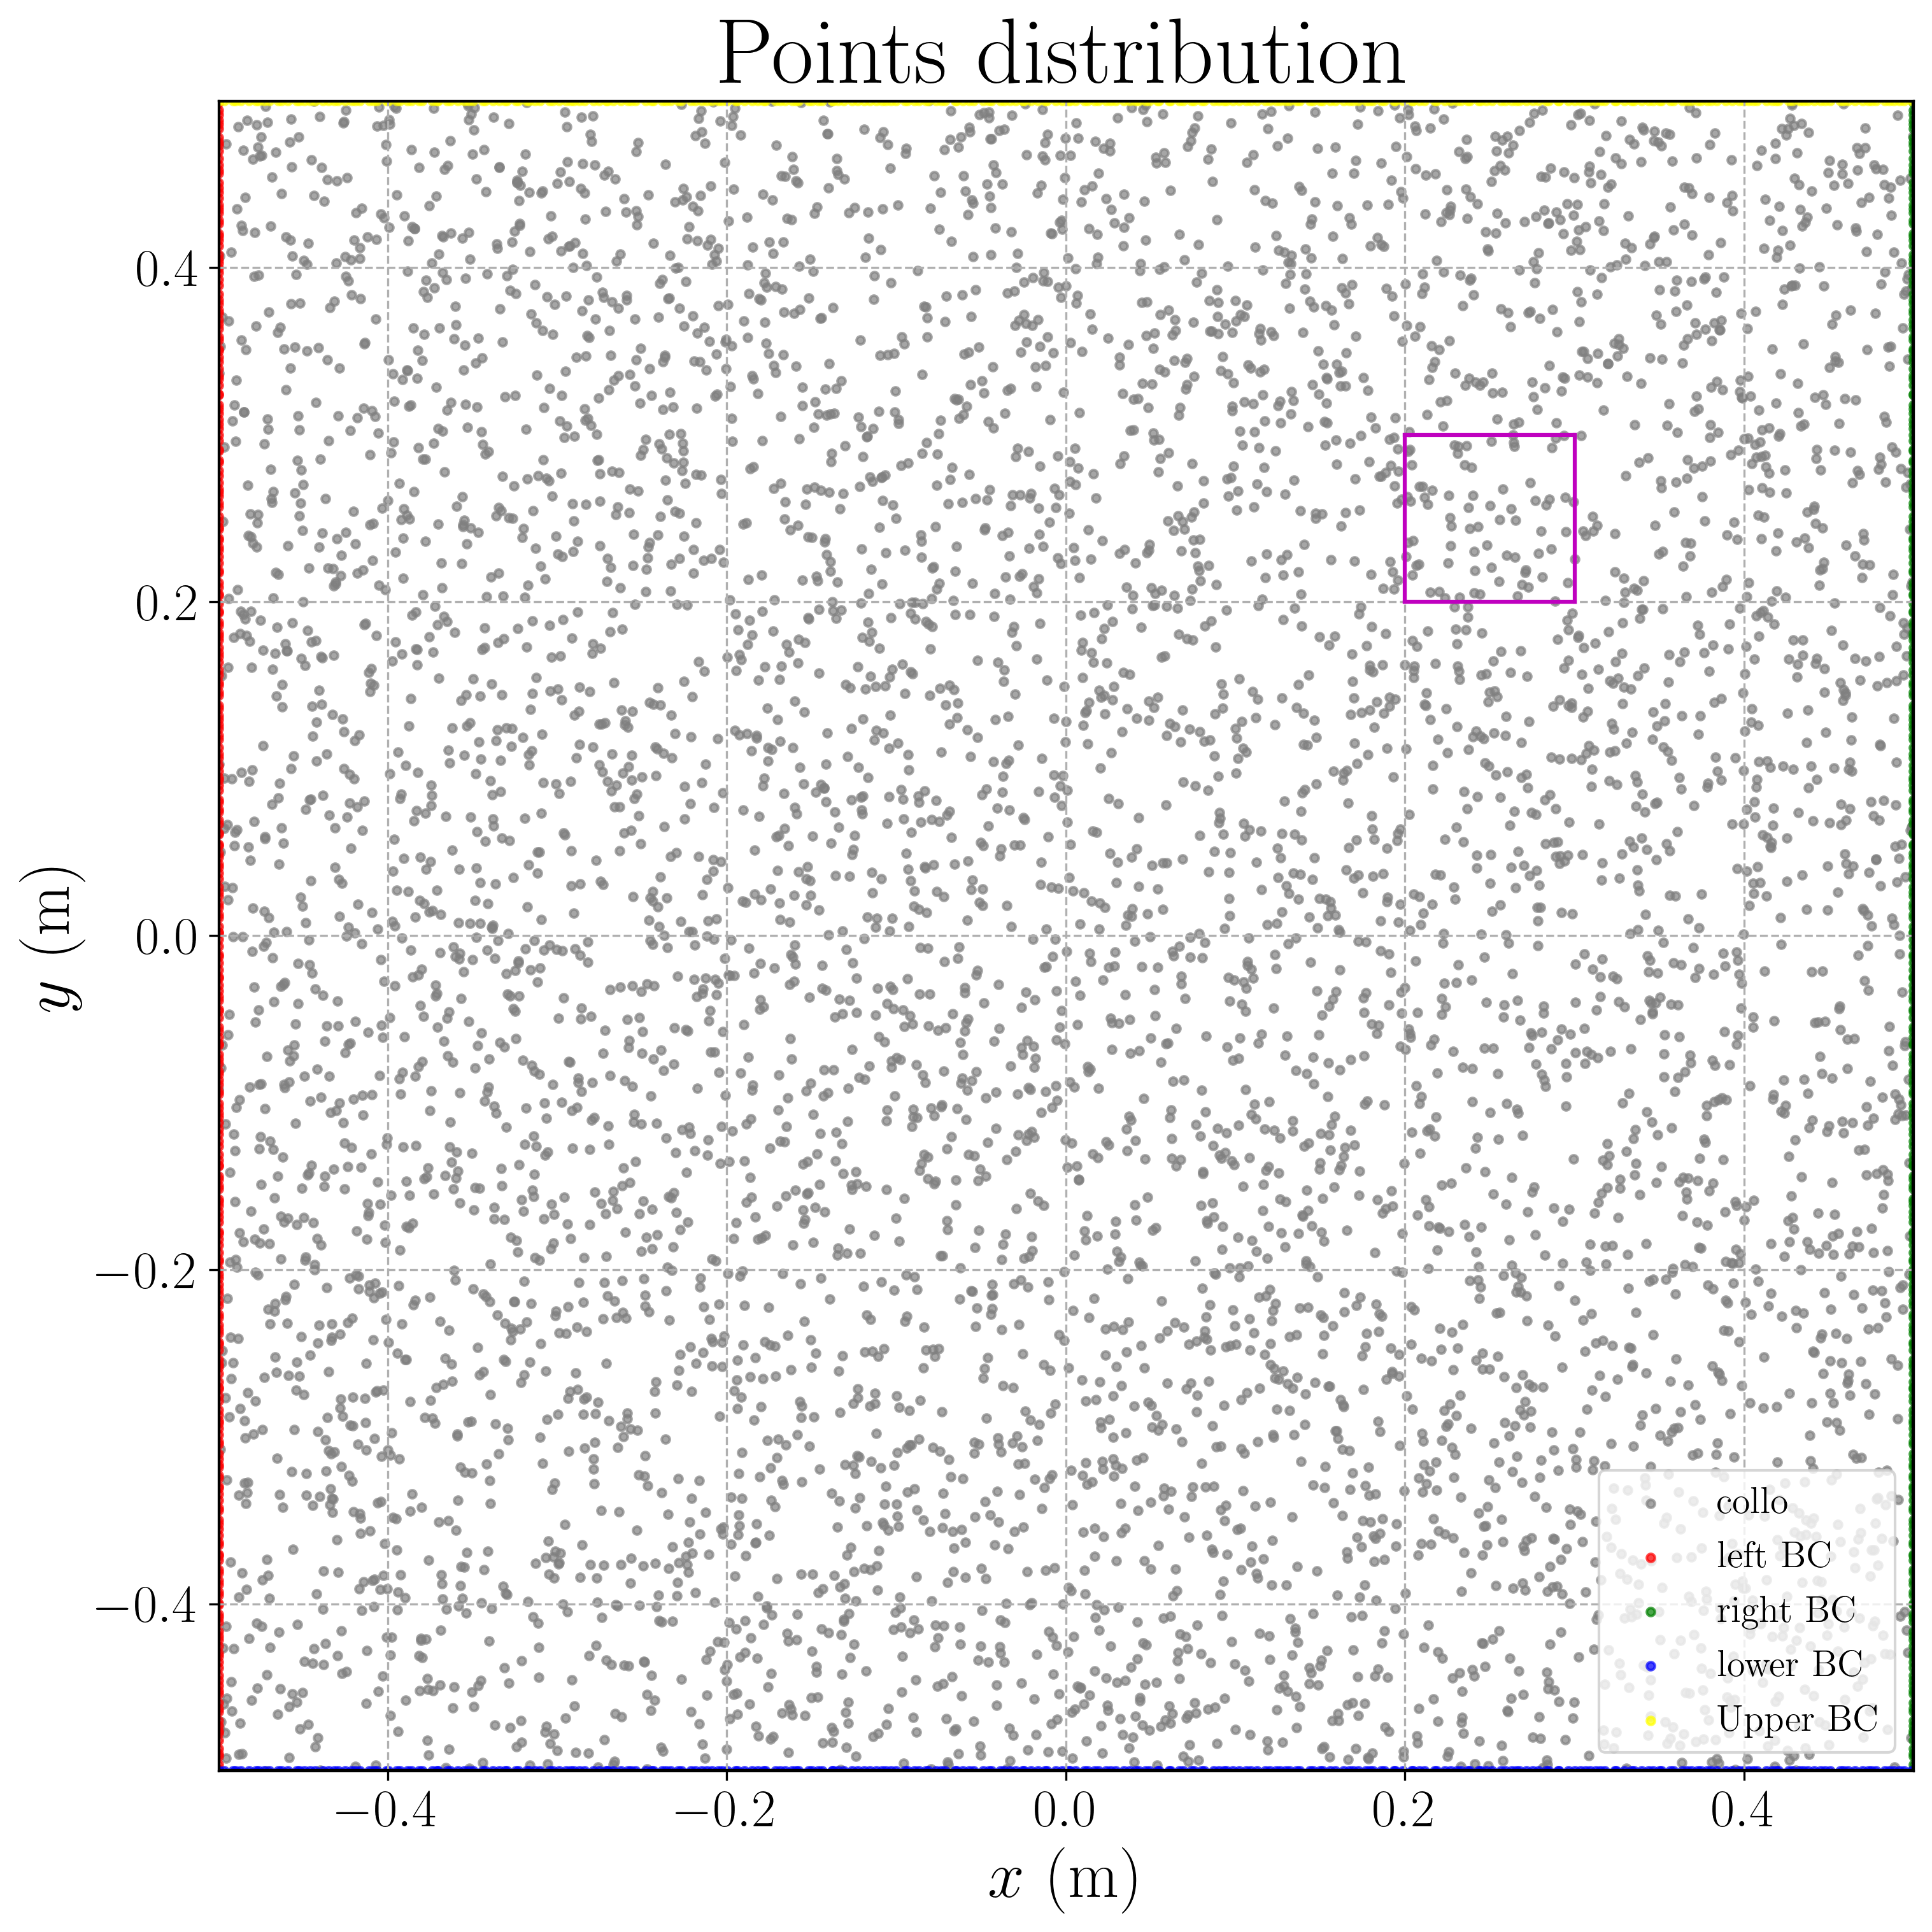

In [49]:
params = generate_param()
params["network"]["layers"] = [2] + 3*[30] + [1]
params["network"]["adaptive_coef"] =  True
params["network"]["scale_factor"] = 1.0
params["network"]["coef_bc"] =  1.0

case = Plate()
case.generate_train_data(param=params)
case.plot()

##### Generate Test Data

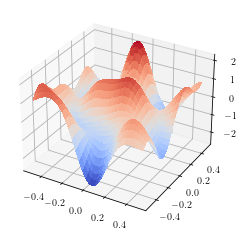

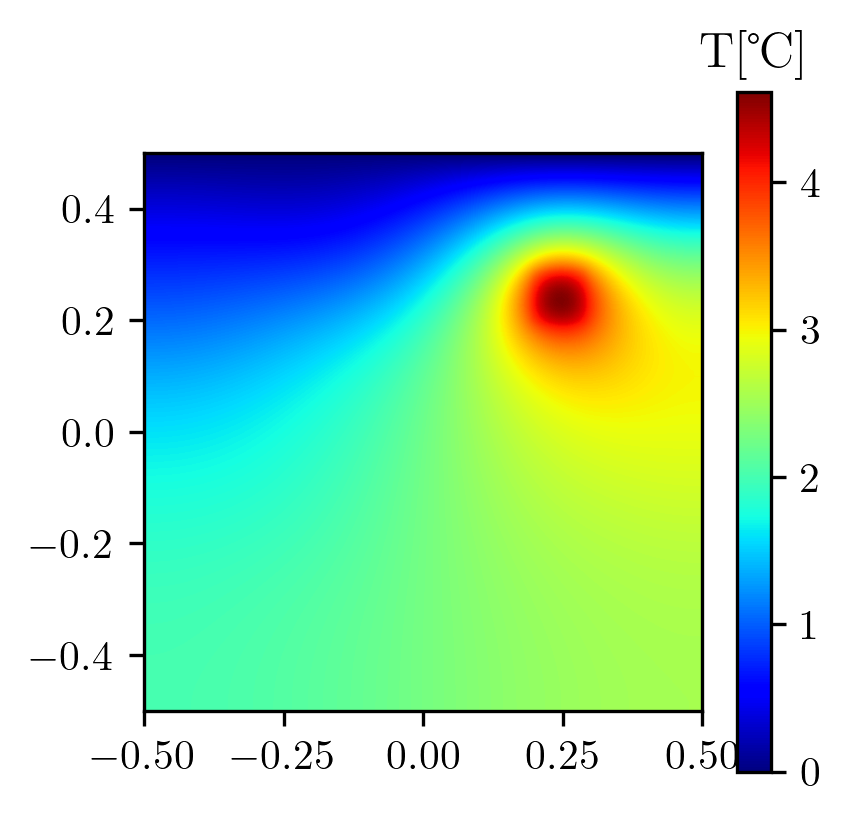

In [50]:
case.generate_test_data(param=params)

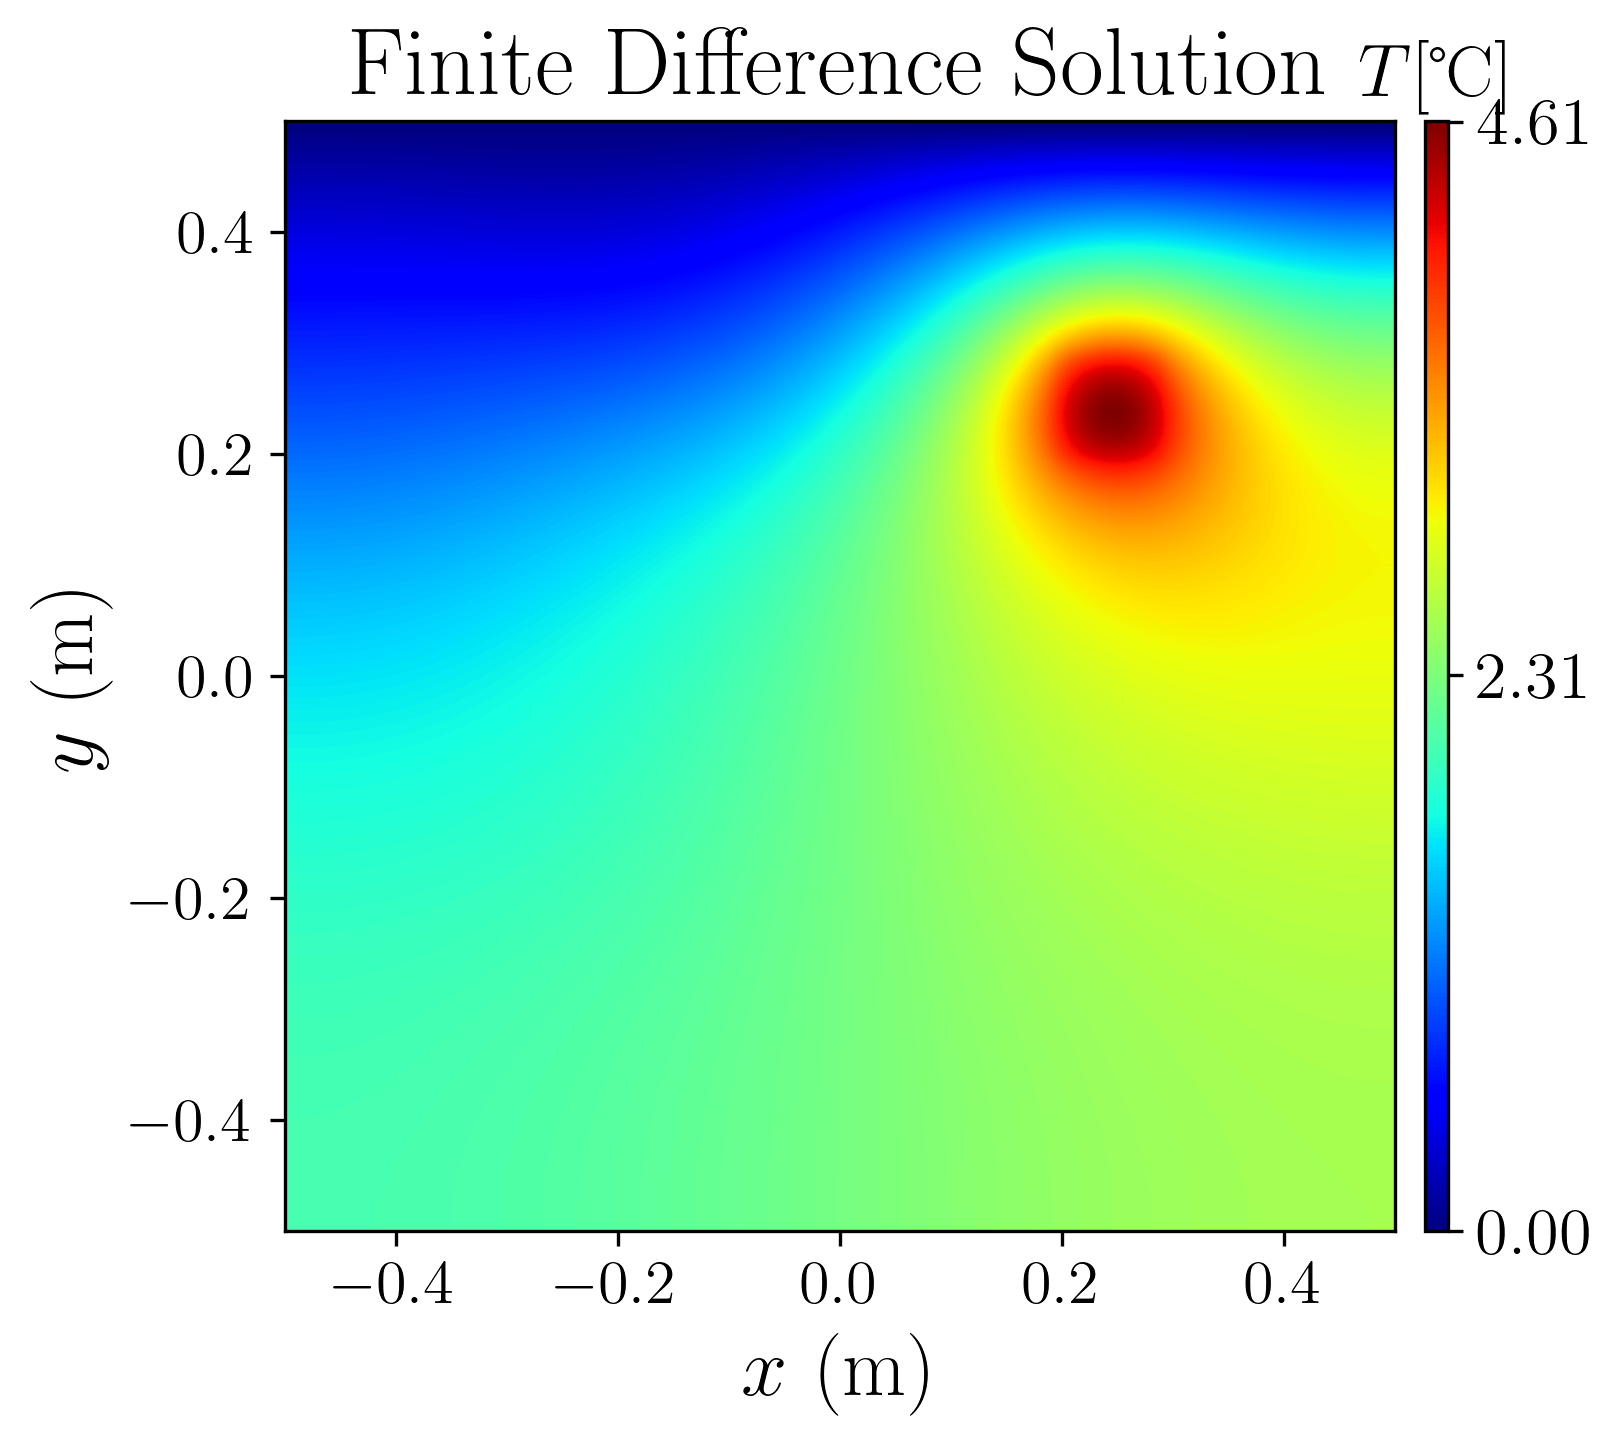

In [51]:
phi_ = case.data["test"][:,2].reshape(101,101)
vmin = np.min(phi_)
vmax = np.max(phi_)

fig_w = fig_h = 5.0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)


cf = ax.imshow(phi_, cmap=cm.jet, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', interpolation='bilinear')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)

ax.set_title("Finite Difference Solution", fontsize=23)

ax.set_xlabel('$x$ (m)', fontsize=20)
ax.set_ylabel('$y$ (m)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cb = fig.colorbar(cf, cax=cax)

ticks = np.linspace(vmin, vmax, 3)
ticks = np.round(ticks, 2)
cb.set_ticks(ticks)
cb.ax.tick_params(labelsize=16)
cb.ax.set_title("$T$[\u2103]", fontsize=18)

plt.show()

##### **Run**

###### Main

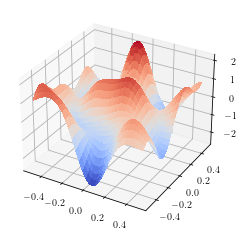

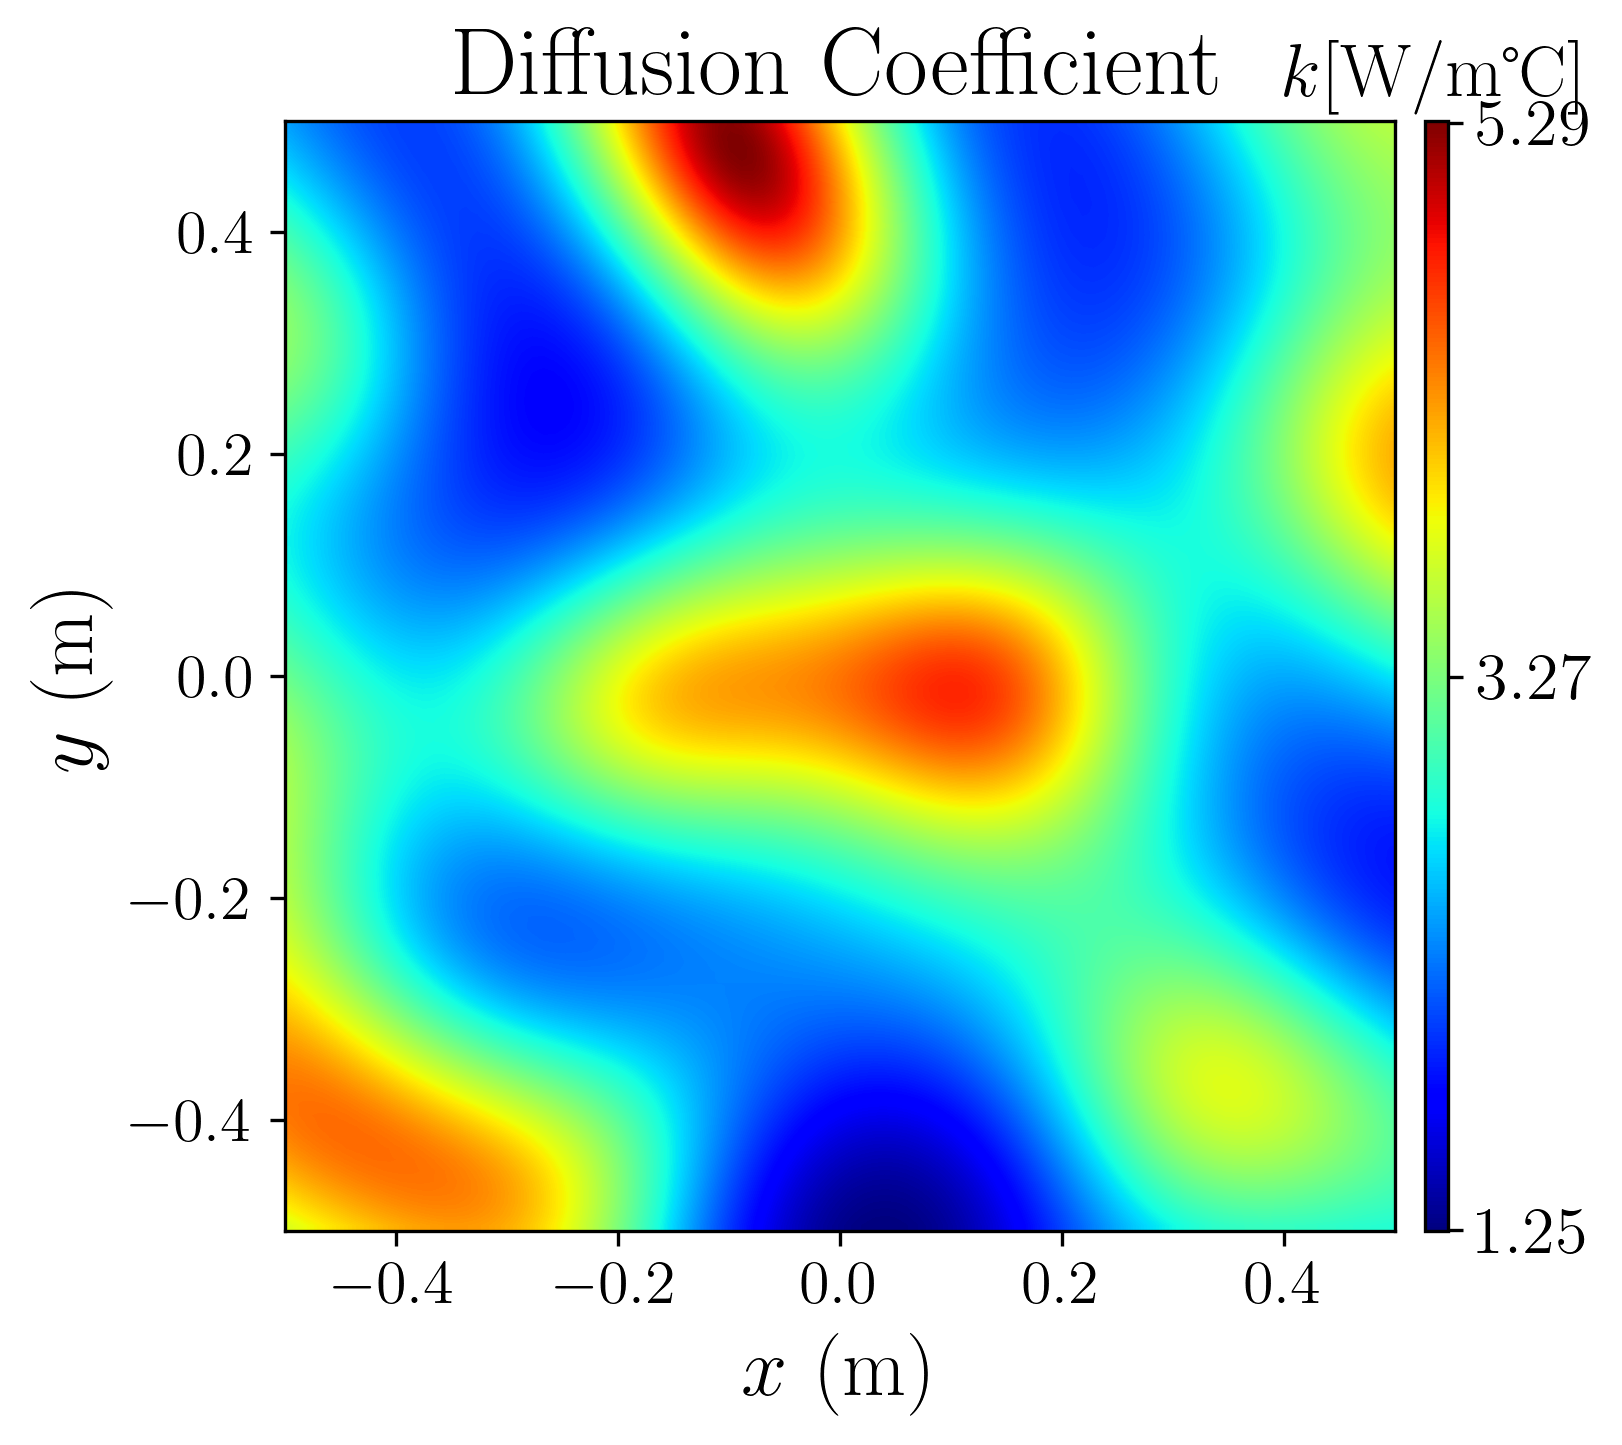

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1



In [52]:
# Create Model Instance
model = PinnVP(data=case.data, params=params)

In [53]:
model.fit_adam()
model.fit_newton()

START TRAINING ADAM
-------------------------------------------------------------
iter: 0, Loss Test: 2.0045e+00, Loss Total: 4.8486e+04, Loss Collo: 4.8475e+04, Loss Neumann: 1.0615e+01, Loss Dirichlet: 2.7147e-01, time: 3.11s
coef coefficients: 1.010000
Save NN parameters successfully...
model & loss saved
iter: 100, Loss Test: 2.0445e+00, Loss Total: 5.1162e+03, Loss Collo: 5.0311e+03, Loss Neumann: 8.4475e+01, Loss Dirichlet: 6.8095e-01, time: 3.06s
coef coefficients: 1.482876
iter: 200, Loss Test: 1.2007e+00, Loss Total: 1.8116e+03, Loss Collo: 1.7784e+03, Loss Neumann: 3.3003e+01, Loss Dirichlet: 1.9298e-01, time: 2.44s
coef coefficients: 1.604625
iter: 300, Loss Test: 7.2048e-01, Loss Total: 9.3559e+02, Loss Collo: 9.1352e+02, Loss Neumann: 2.1968e+01, Loss Dirichlet: 9.3910e-02, time: 2.52s
coef coefficients: 1.678468
iter: 400, Loss Test: 6.5147e-01, Loss Total: 6.9976e+02, Loss Collo: 6.8023e+02, Loss Neumann: 1.9389e+01, Loss Dirichlet: 1.4264e-01, time: 2.30s
coef coefficie

iter: 1800, Loss_Test: 5.6179e-02, Loss Total: 1.1368e+00, Loss Collo: 1.0937e+00, Loss Neumann: 3.3085e-02, Loss Dirichlet: 1.0057e-02, coef: 8.4751e+00
iter: 1900, Loss_Test: 7.2394e-02, Loss Total: 1.0139e+00, Loss Collo: 9.8221e-01, Loss Neumann: 2.5153e-02, Loss Dirichlet: 6.5300e-03, coef: 8.7474e+00
iter: 2000, Loss_Test: 8.6771e-02, Loss Total: 8.9969e-01, Loss Collo: 8.7681e-01, Loss Neumann: 1.9024e-02, Loss Dirichlet: 3.8567e-03, coef: 9.0191e+00
iter: 2100, Loss_Test: 8.0382e-02, Loss Total: 8.1303e-01, Loss Collo: 7.9469e-01, Loss Neumann: 1.5959e-02, Loss Dirichlet: 2.3825e-03, coef: 9.2339e+00
iter: 2200, Loss_Test: 7.1806e-02, Loss Total: 7.3230e-01, Loss Collo: 7.2007e-01, Loss Neumann: 1.1190e-02, Loss Dirichlet: 1.0410e-03, coef: 9.4773e+00
iter: 2300, Loss_Test: 5.6915e-02, Loss Total: 6.7307e-01, Loss Collo: 6.5974e-01, Loss Neumann: 1.2652e-02, Loss Dirichlet: 6.7804e-04, coef: 9.6703e+00
iter: 2400, Loss_Test: 4.9837e-02, Loss Total: 6.0975e-01, Loss Collo: 6.005

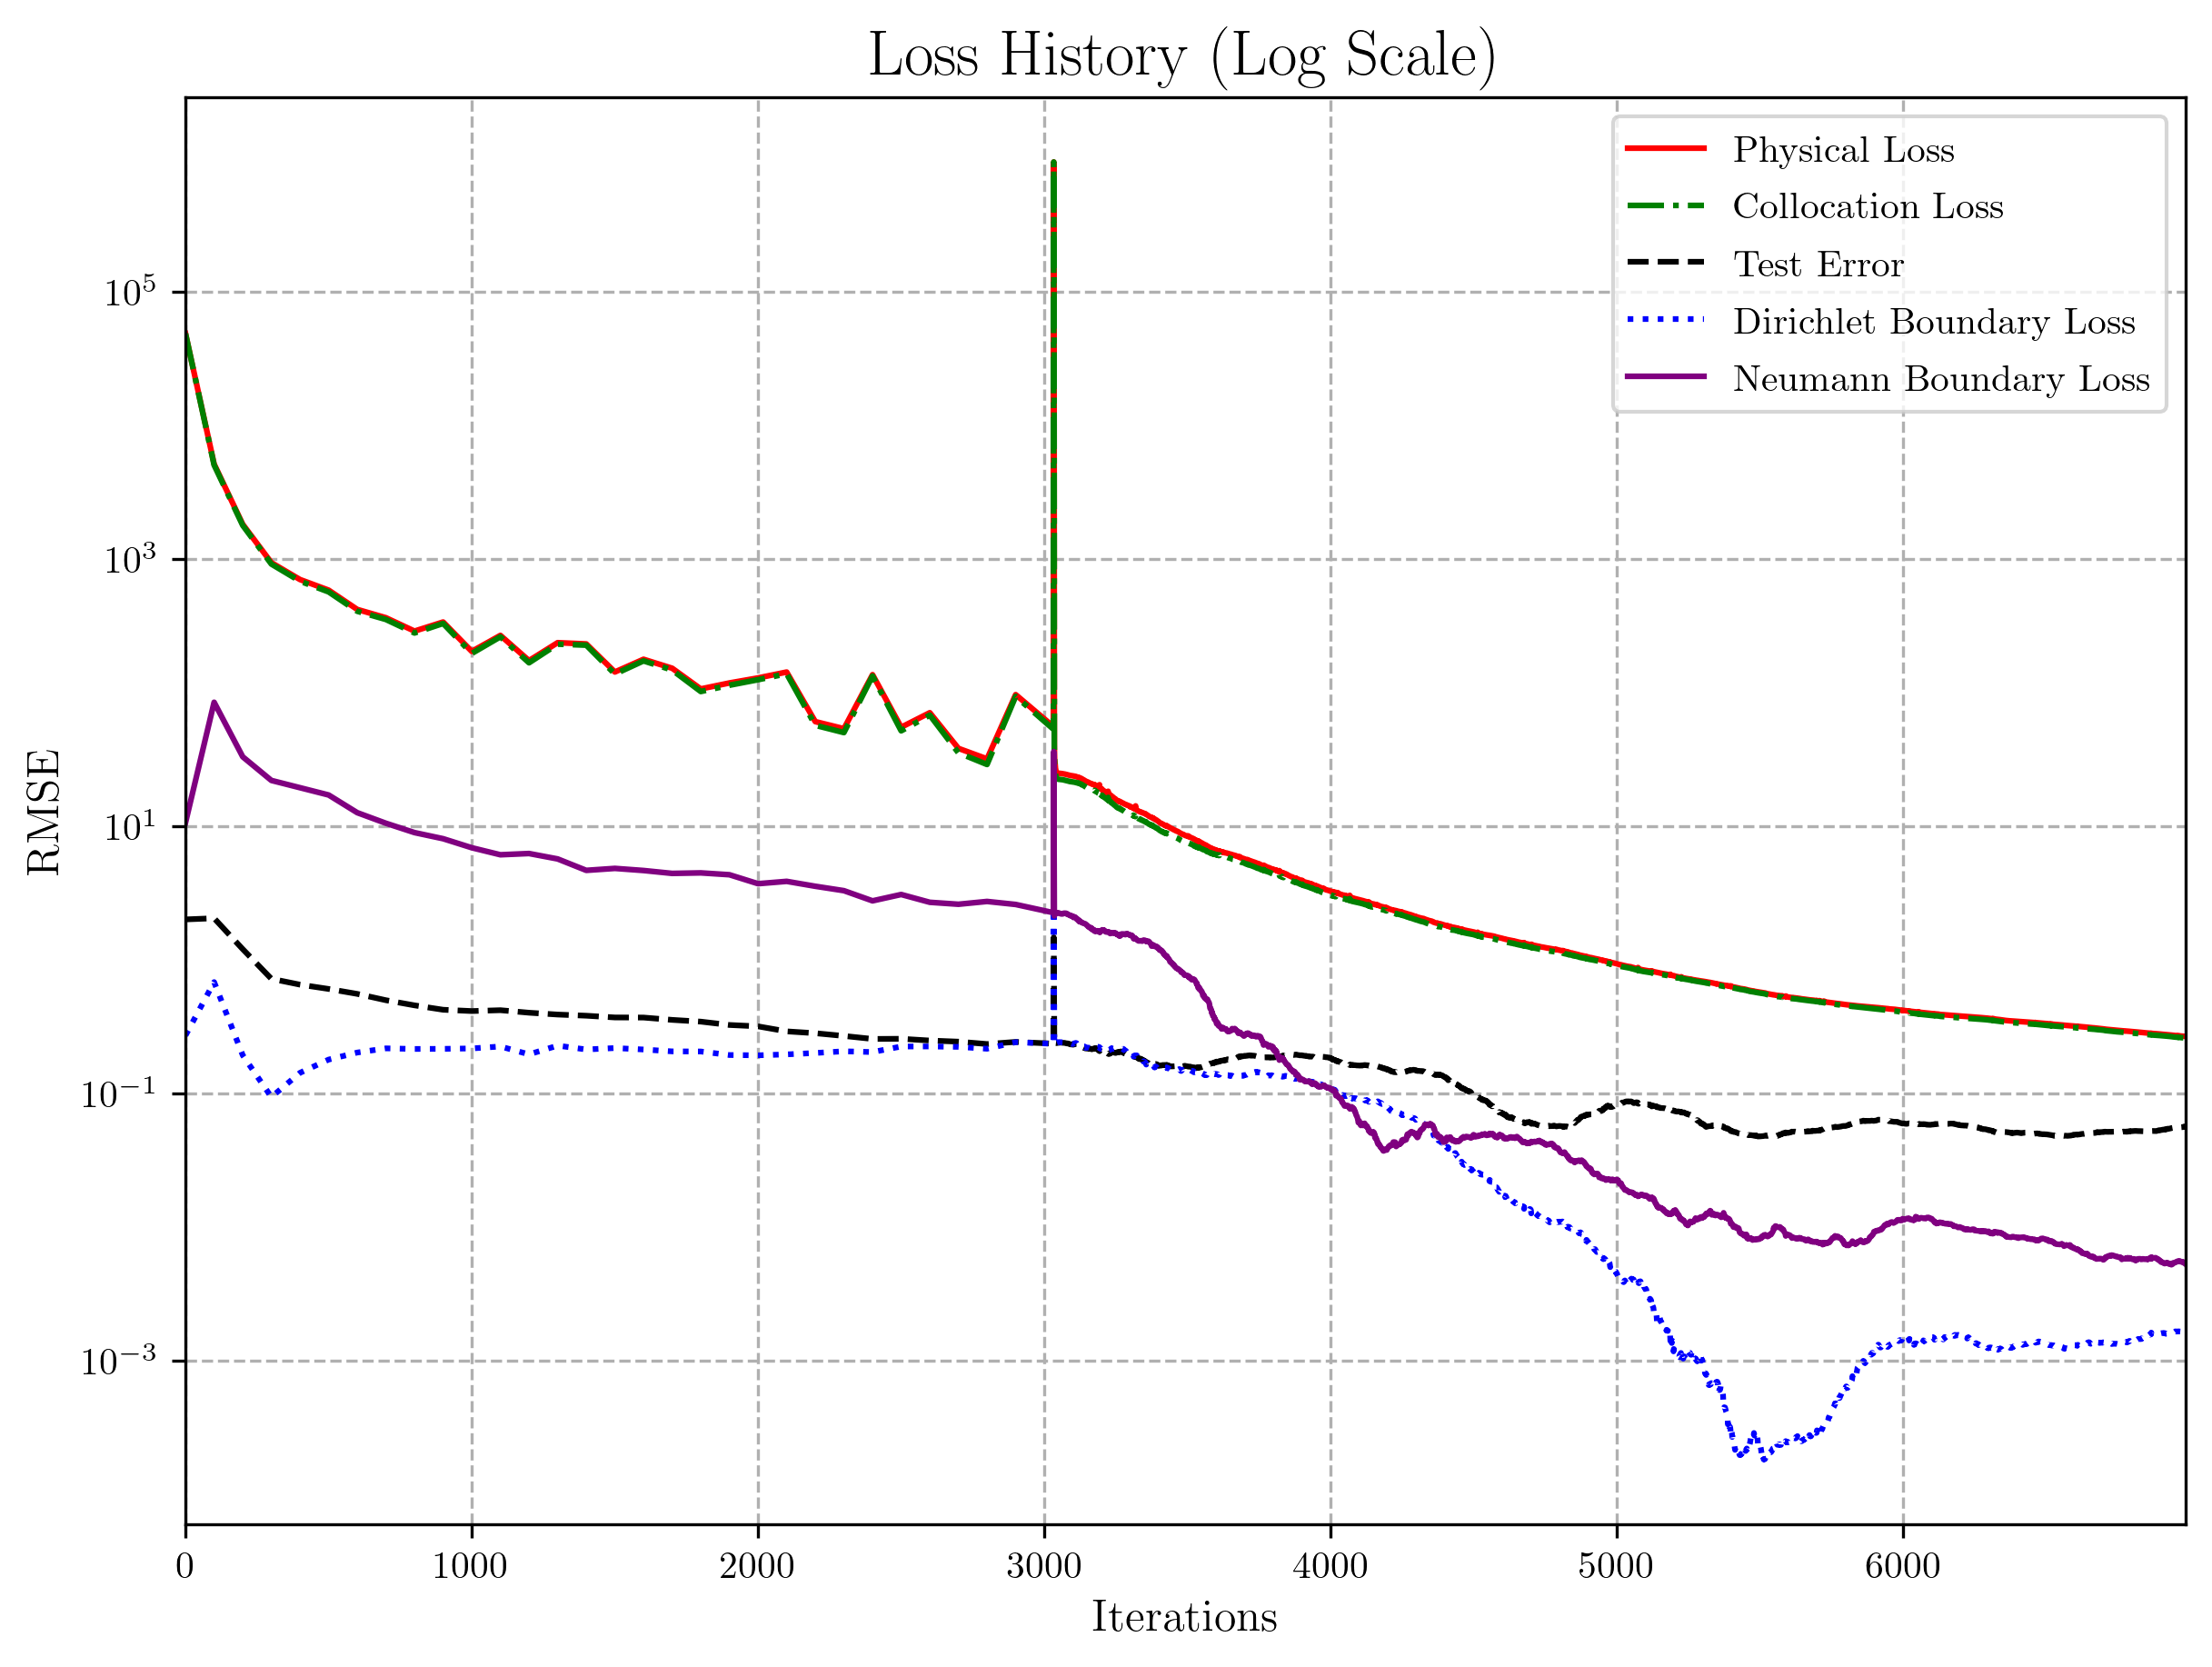

- Last Iterations: 6987
Absolute Error: 0.048725
Relative Error (%):   inf
RMSE: 0.056511
R Square (%): 99.552474


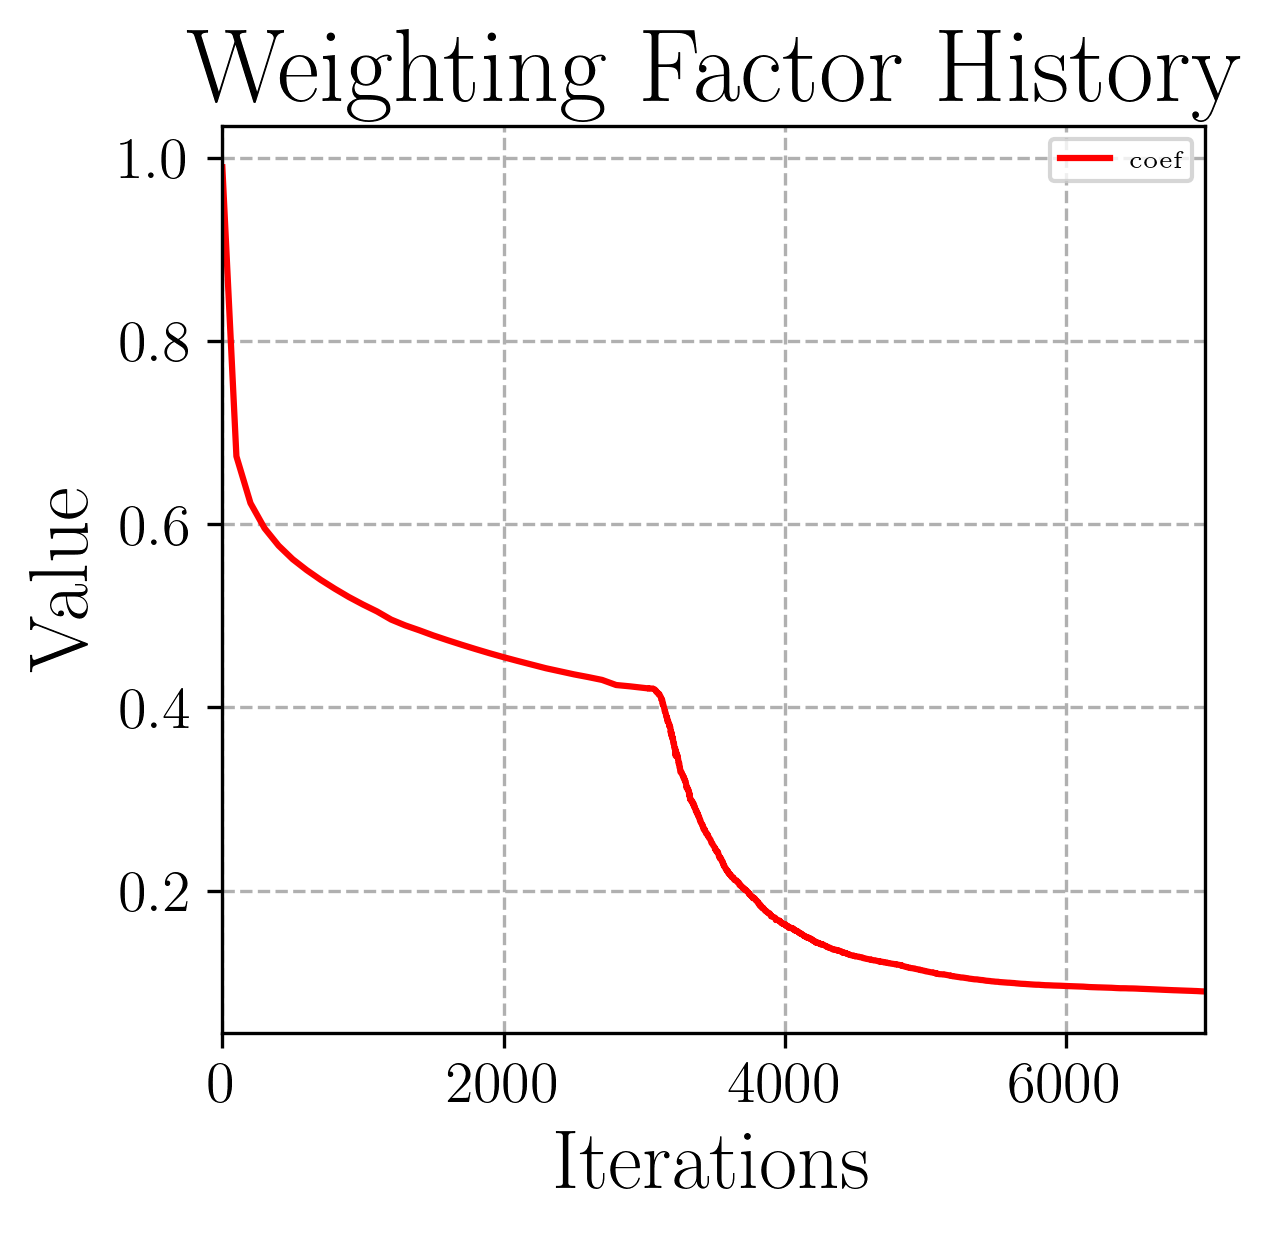

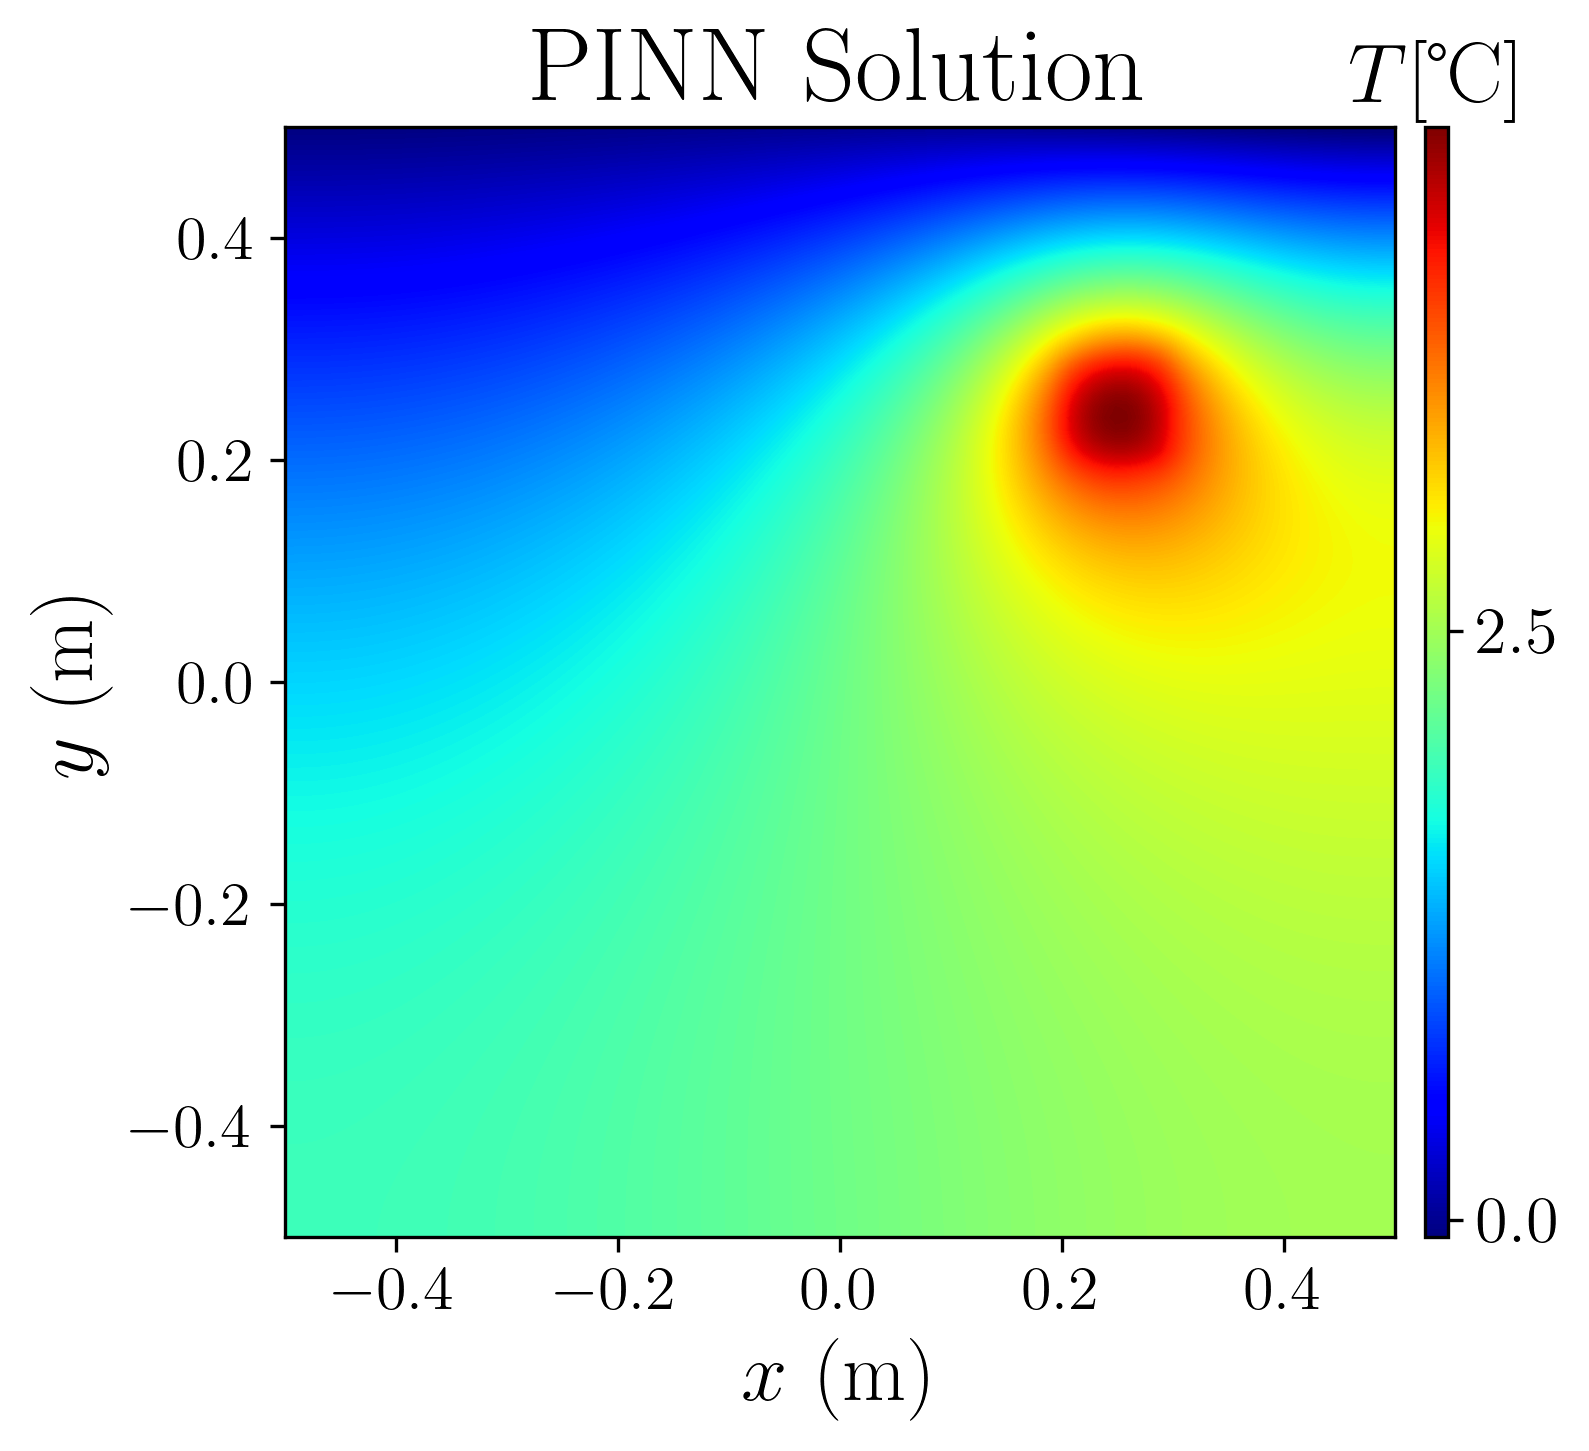

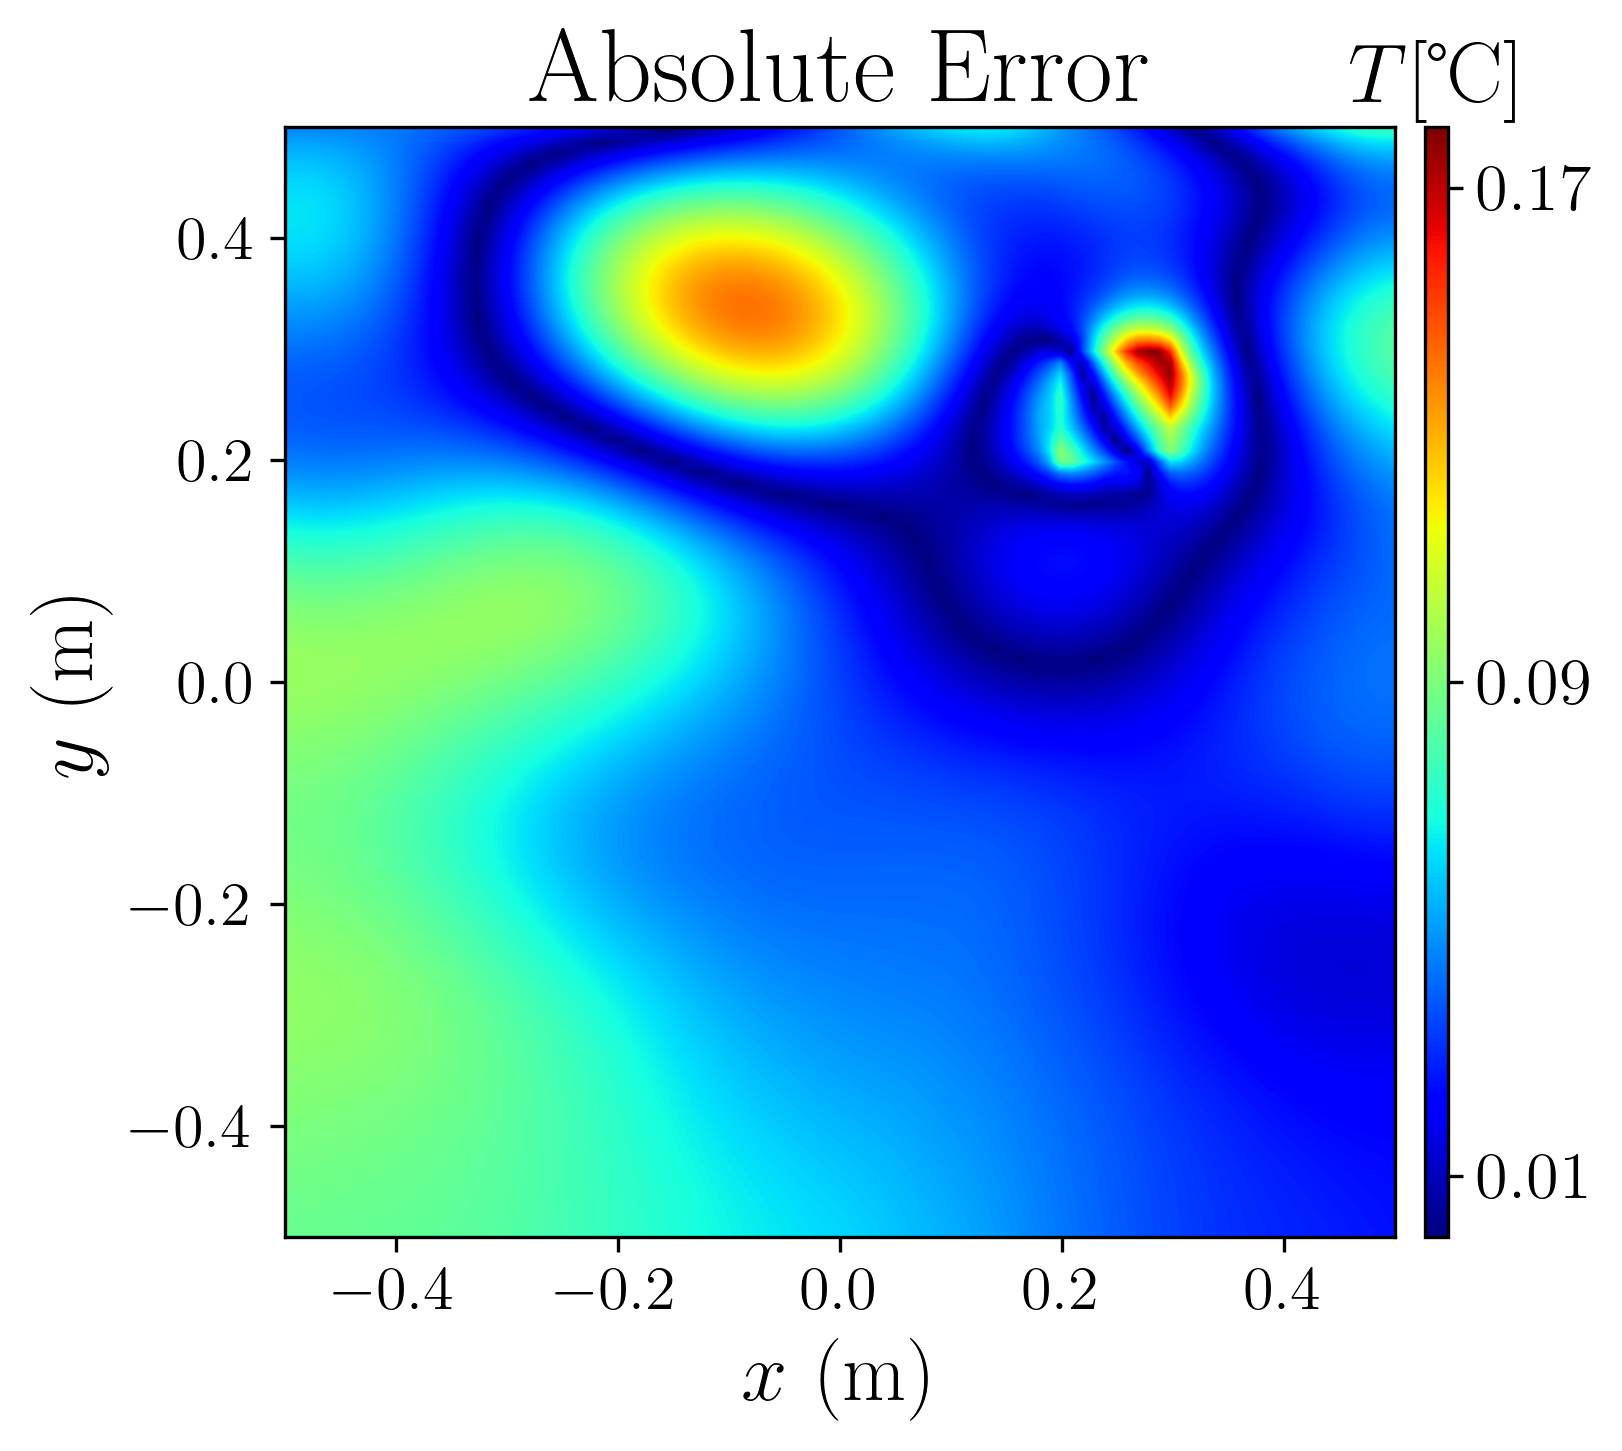

In [60]:
# Create Results
results = PostChannel(model=model,
                      params=params,
                      save_fig=False)

results.display_loss()
results.display_contour()